In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

## Check grades

In [3]:
df = pd.read_csv(r'../../data/tidy/large/trajectories-mapped-powertrain-weight-grade-oct2021-sep2022.csv', delimiter=',', skiprows=0, low_memory=False)

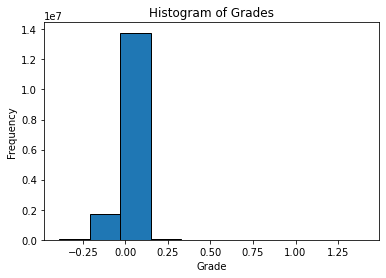

In [7]:
plt.hist(df['grade'], bins=10, edgecolor='black') 
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.title('Histogram of Grades')
plt.show()

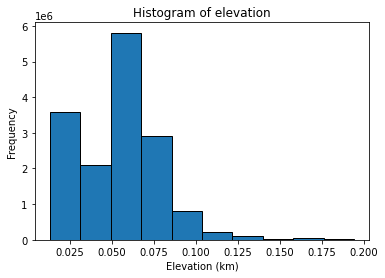

In [12]:
plt.hist(df['elevation']/1000, bins=10, edgecolor='black') 
plt.xlabel('Elevation (km)')
plt.ylabel('Frequency')
plt.title('Histogram of elevation')
plt.show()

In [13]:
df['elevation'].mean()/1000

0.055111867799110606

## Check MPGs

### BEB

In [25]:
df = pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

In [26]:
validation_beb= pd.read_excel(r'../../data/tidy/BEB-validation.xlsx')

In [27]:
df_beb=df[df['Powertrain'] == 'electric'].copy()
df_cdb=df[df['Powertrain'] == 'conventional'].copy()
df_heb=df[df['Powertrain'] == 'hybrid'].copy()

In [28]:
# Convert date columns to datetime if they are not already
df_beb['Date'] = pd.to_datetime(df_beb['Date'])
validation_beb['Transaction Date'] = pd.to_datetime(validation_beb['Transaction Date'])

# Group by Date and Vehicle in df_beb and sum the Energy
grouped_energy = df_beb.groupby(['Date', 'Vehicle'])[['Energy', 'dist']].sum().reset_index()

# Merge the dataframes
merged_df = pd.merge(validation_beb, grouped_energy, 
                     left_on=['Transaction Date', 'Equipment ID'], 
                     right_on=['Date', 'Vehicle'], 
                     how='left')

In [29]:
# Drop rows where 'trip' or 'Predicted Energy' is NaN
merged_df = merged_df.dropna(subset=['trip', 'Energy'])

# Drop rows where 'trip' or 'Predicted Energy' is 0
merged_df = merged_df.query("trip != 0 and `Energy` != 0")
merged_df

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
0            3501   26.7    35.0       2022-06-01 2022-06-01   3501.0   
1            3501  167.1   182.7       2022-06-02 2022-06-02   3501.0   
3            3501  173.9   166.1       2022-06-06 2022-06-06   3501.0   
4            3501   74.3   180.0       2022-06-07 2022-06-07   3501.0   
5            3501   81.4   108.5       2022-06-08 2022-06-08   3501.0   
..            ...    ...     ...              ...        ...      ...   
269          1321  141.5     0.8       2022-09-26 2022-09-26   1321.0   
270          1321  139.1   390.0       2022-09-27 2022-09-27   1321.0   
271          1321  194.8     3.1       2022-09-28 2022-09-28   1321.0   
272          1321  116.0   387.8       2022-09-29 2022-09-29   1321.0   
273          1321  193.6     0.9       2022-09-30 2022-09-30   1321.0   

         Energy        dist  
0     33.734389   15.759902  
1    219.520662   96.860943  
3    212.339484   97.573532  
4    117.440518   44.192232  
5    100.004826   43.615372  
..          ...         ...  
269  178.071729   88.931381  
270  137.503337   63.968701  
271  195.651297  102.720630  
272   79.697589   42.246626  
273  181.901215  100.532695  

[185 rows x 8 columns]

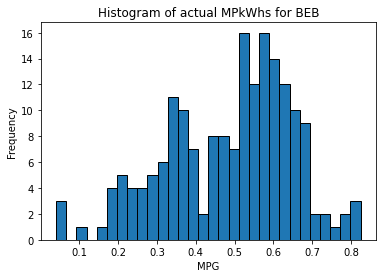

In [30]:
merged_df['actual_mpg']=merged_df['dist']/merged_df['trip']
merged_df['pred_mpg']=merged_df['dist']/merged_df['Energy']
plt.hist(merged_df['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPkWhs for BEB')
plt.show()

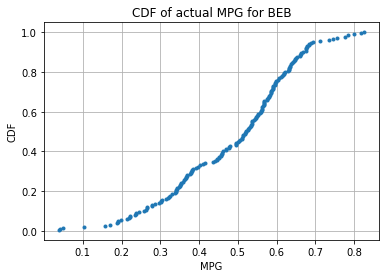

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df['actual_mpg'] contains your data
data = merged_df['actual_mpg']

# Calculate the CDF values
data_sorted = np.sort(data)
cdf = np.arange(1, len(data_sorted)+1) / len(data_sorted)

# Create a CDF plot
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('MPG')
plt.ylabel('CDF')
plt.title('CDF of actual MPG for BEB')
plt.grid(True)
plt.show()


In [32]:
top_10_rows = merged_df.nlargest(10, 'actual_mpg')
print(top_10_rows)

     Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
100          1322  186.3     0.0       2022-08-11 2022-08-11   1322.0   
151          1322  189.8   284.3       2022-07-25 2022-07-25   1322.0   
104          1322  152.6     0.9       2022-08-19 2022-08-19   1322.0   
188          1321   16.9   121.1       2022-06-13 2022-06-13   1321.0   
142          1322  157.2   240.6       2022-07-13 2022-07-13   1322.0   
252          1321   80.5   234.8       2022-09-08 2022-09-08   1321.0   
196          1321   85.8     0.0       2022-06-24 2022-06-24   1321.0   
102          1322   92.8   395.4       2022-08-15 2022-08-15   1322.0   
113          7700   99.5   162.9       2022-07-07 2022-07-07   7700.0   
264          1321   19.1   157.9       2022-09-21 2022-09-21   1321.0   

         Energy        dist  actual_mpg  pred_mpg  
100  309.985130  153.645414    0.824720  0.495654  
151  248.397568  154.959114    0.816434  0.623835  
104  241.421625  122.193691    0.800745 

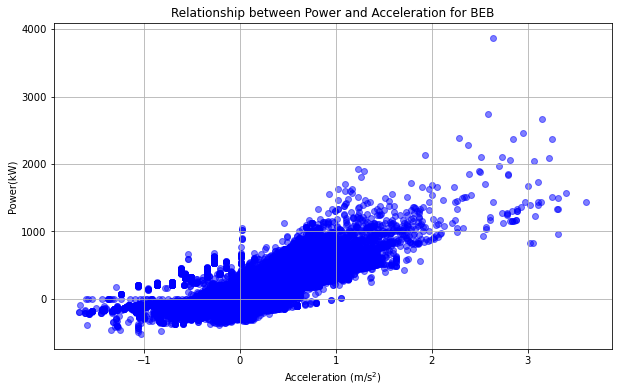

In [33]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_beb['Acceleration'],df_beb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for BEB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

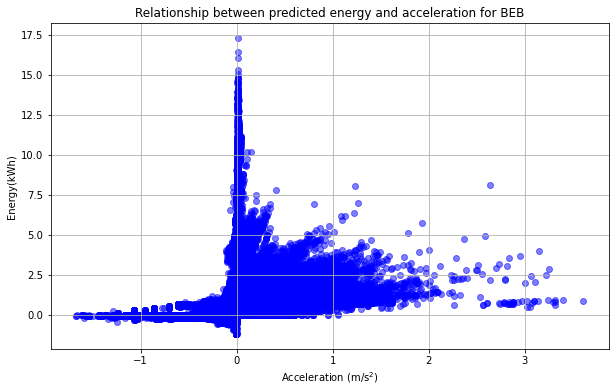

In [34]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_beb['Acceleration'],df_beb['Energy'], color='blue', alpha=0.5)
plt.title('Relationship between predicted energy and acceleration for BEB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Energy(kWh)')
plt.grid(True)
plt.show()

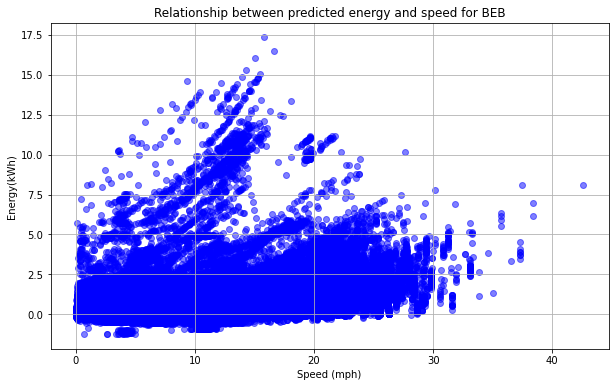

In [35]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_beb['Speed'],df_beb['Energy'], color='blue', alpha=0.5)
plt.title('Relationship between predicted energy and speed for BEB')
plt.xlabel(r'Speed (mph)')
plt.ylabel('Energy(kWh)')
plt.grid(True)
plt.show()

In [36]:
df_cdb.loc[df_cdb['power']>30000]

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
5049646       5050247       5050247       3248633       3248633     3248633   
9386168       9387152       9387152       3138491       3138491     3138491   
9386169       9387153       9387153       3138466       3138466     3138466   
9386184       9387168       9387168       3138480       3138480     3138480   

             ServiceDateTime  DateKey             CalendarDate  Year  Month  \
5049646  2021-11-10 11:44:29     8618  2021-11-10 00:00:00.000  2021     11   
9386168  2021-11-08 15:40:39     8616  2021-11-08 00:00:00.000  2021     11   
9386169  2021-11-08 15:41:15     8616  2021-11-08 00:00:00.000  2021     11   
9386184  2021-11-08 16:08:17     8616  2021-11-08 00:00:00.000  2021     11   

         ...    VehicleModel Vehicle_mass  time_delta_in_seconds      dist  \
5049646  ...  NEW FLYER XD35        26900                     29  3.258536   
9386168  ...  NEW FLYER XD40        28250                     74  7.459224   
9386169  ...  NEW FLYER XD40        28250                     36  6.999998   
9386184  ...  NEW FLYER XD40        28250                     61  6.485929   

              Speed Acceleration  elevation     grade          power  \
5049646  180.831201     3.867568       74.0  0.002669   53550.242665   
9386168  162.222401     1.339787       85.0  0.001915   34368.806732   
9386169  312.927906     2.601226       72.0 -0.001154  232429.425285   
9386184  171.116248     1.668396       86.0  0.000096   40738.510174   

              Energy  
5049646   268.521615  
9386168   310.898677  
9386169  5400.796118  
9386184   345.589658  

[4 rows x 47 columns]

In [37]:
df_cdb=df_cdb.loc[df_cdb['power']<30000]

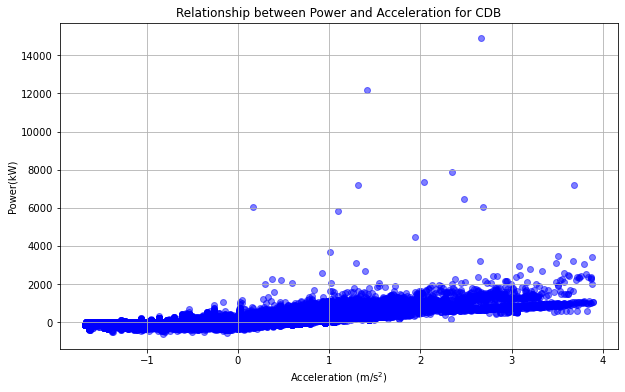

In [38]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_cdb['Acceleration'],df_cdb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for CDB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

In [39]:
df_heb.loc[df_heb['power']>10000]

Unnamed: 0.4  Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
6454114       6454837       6454837       3139979       3139979     3139979   
6454115       6454838       6454838       3140232       3140232     3140232   
6454119       6454842       6454842       3139981       3139981     3139981   
6454147       6454873       6454873       3140260       3140260     3140260   

             ServiceDateTime  DateKey             CalendarDate  Year  Month  \
6454114  2021-11-08 09:10:19     8616  2021-11-08 00:00:00.000  2021     11   
6454115  2021-11-08 09:11:12     8616  2021-11-08 00:00:00.000  2021     11   
6454119  2021-11-08 09:14:07     8616  2021-11-08 00:00:00.000  2021     11   
6454147  2021-11-08 09:32:29     8616  2021-11-08 00:00:00.000  2021     11   

         ...     VehicleModel Vehicle_mass  time_delta_in_seconds      dist  \
6454114  ...  NEW FLYER XDE40        28250                     47  6.212168   
6454115  ...  NEW FLYER XDE40        28250                     53  6.065792   
6454119  ...  NEW FLYER XDE40        28250                     64  4.786467   
6454147  ...  NEW FLYER XDE40        28250                     51  4.762854   

              Speed Acceleration  elevation     grade         power  \
6454114  212.713102     2.696225       20.0 -0.004899  83519.906173   
6454115  184.187674    -0.334432       77.0  0.005837  46915.022908   
6454119  120.360502     1.016915       26.0 -0.005840  15565.830994   
6454147  150.295491     1.735923       33.0 -0.004956  30644.461887   

             Energy  
6454114  958.402386  
6454115  366.646795  
6454119   64.409503  
6454147  163.283485  

[4 rows x 47 columns]

In [40]:
df_heb=df_heb.loc[df_heb['power']<10000]

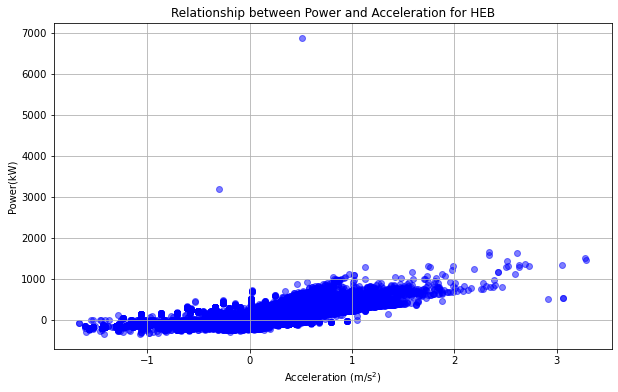

In [41]:
# Plot
plt.figure(figsize=(10, 6))
plt.scatter(df_heb['Acceleration'],df_heb['power'], color='blue', alpha=0.5)
plt.title('Relationship between Power and Acceleration for HEB')
plt.xlabel(r'Acceleration (m/s$^2$)')
plt.ylabel('Power(kW)')
plt.grid(True)
plt.show()

In [42]:
# Calculate Absolute Percentage Error (APE) for each row
merged_df['APE'] = (abs(merged_df['trip'] - merged_df['Energy']) / merged_df['trip']) * 100
top_20_mape = merged_df.nlargest(20, 'APE')
top_20_mape

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
67           1323   30.0     0.0       2022-04-29 2022-04-29   1323.0   
211          1323   15.4    17.5       2022-05-16 2022-05-16   1323.0   
213          1321   89.8   154.6       2022-05-18 2022-05-18   1321.0   
217          1321   91.1     0.0       2022-05-25 2022-05-25   1321.0   
59           1323   40.5     0.0       2022-04-14 2022-04-14   1323.0   
102          1322   92.8   395.4       2022-08-15 2022-08-15   1322.0   
215          1321   46.5     0.0       2022-05-20 2022-05-20   1321.0   
64           1323   23.0    22.0       2022-04-25 2022-04-25   1323.0   
63           1323   85.1   103.8       2022-04-21 2022-04-21   1323.0   
180          1321   62.4     0.0       2022-06-02 2022-06-02   1321.0   
187          1321   18.8     0.0       2022-06-10 2022-06-10   1321.0   
160          1421   21.0    50.6       2022-06-09 2022-06-09   1421.0   
29           3501  214.8   320.6       2022-08-03 2022-08-03   3501.0   
227          1420   30.0     0.0       2022-09-08 2022-09-08   1420.0   
114          1421  234.0    84.9       2022-07-08 2022-07-08   1421.0   
44           3501  213.0   351.1       2022-08-24 2022-08-24   3501.0   
100          1322  186.3     0.0       2022-08-11 2022-08-11   1322.0   
71           1421  201.7     0.7       2022-08-05 2022-08-05   1421.0   
179          1321   75.3   202.3       2022-06-01 2022-06-01   1321.0   
83           1420  180.8     1.3       2022-08-25 2022-08-25   1420.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
67     0.812544    1.470162    0.049005  1.809332  97.291519  
211    1.327148    0.626032    0.040651  0.471713  91.382155  
213    8.307459    3.577301    0.039836  0.430613  90.748932  
217    9.018004    9.470920    0.103962  1.050223  90.100983  
59     6.412037    9.528018    0.235260  1.485958  84.167810  
102  168.392690   68.253775    0.735493  0.405325  81.457640  
215    9.551027   10.272495    0.220914  1.075538  79.460157  
64     4.914100    6.098154    0.265137  1.240950  78.634347  
63    19.450688   14.524731    0.170678  0.746746  77.143727  
180   14.461254   15.230013    0.244071  1.053160  76.824914  
187    5.243280    4.440169    0.236179  0.846830  72.110213  
160    6.040987    4.184522    0.199263  0.692688  71.233394  
29   363.379860  135.687219    0.631691  0.373403  69.171257  
227    9.280673    5.632040    0.187735  0.606857  69.064423  
114  393.867277  154.876640    0.661866  0.393220  68.319349  
44   354.926561  136.375855    0.640262  0.384237  66.632188  
100  309.985130  153.645414    0.824720  0.495654  66.390301  
71    69.327720   56.042432    0.277850  0.808370  65.628300  
179   26.011231   11.944832    0.158630  0.459218  65.456532  
83    62.816083   51.784133    0.286417  0.824377  65.256591

## Validation

### BEB

In [69]:
merged_df['actual_mpg']=merged_df['dist']/merged_df['trip']
merged_df['pred_mpg']=merged_df['dist']/merged_df['Energy']

In [70]:
merged_df

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
0            3501   26.7    35.0       2022-06-01 2022-06-01   3501.0   
1            3501  167.1   182.7       2022-06-02 2022-06-02   3501.0   
3            3501  173.9   166.1       2022-06-06 2022-06-06   3501.0   
4            3501   74.3   180.0       2022-06-07 2022-06-07   3501.0   
5            3501   81.4   108.5       2022-06-08 2022-06-08   3501.0   
..            ...    ...     ...              ...        ...      ...   
269          1321  141.5     0.8       2022-09-26 2022-09-26   1321.0   
270          1321  139.1   390.0       2022-09-27 2022-09-27   1321.0   
271          1321  194.8     3.1       2022-09-28 2022-09-28   1321.0   
272          1321  116.0   387.8       2022-09-29 2022-09-29   1321.0   
273          1321  193.6     0.9       2022-09-30 2022-09-30   1321.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
0     33.734389   15.759902    0.590259  0.467176  26.346027  
1    219.520662   96.860943    0.579659  0.441238  31.370833  
3    212.339484   97.573532    0.561090  0.459517  22.104361  
4    117.440518   44.192232    0.594781  0.376295  58.062608  
5    100.004826   43.615372    0.535815  0.436133  22.856052  
..          ...         ...         ...       ...        ...  
269  178.071729   88.931381    0.628490  0.499413  25.845745  
270  137.503337   63.968701    0.459876  0.465216   1.147852  
271  195.651297  102.720630    0.527313  0.525019   0.437011  
272   79.697589   42.246626    0.364195  0.530087  31.295182  
273  181.901215  100.532695    0.519280  0.552677   6.042761  

[185 rows x 11 columns]

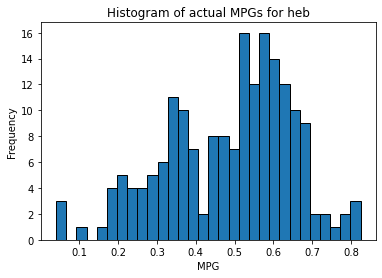

In [71]:
plt.hist(merged_df['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for heb')
plt.show()

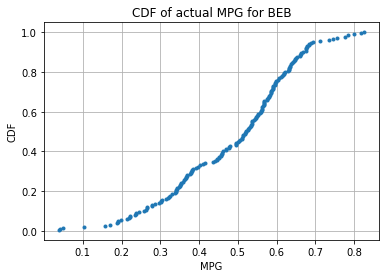

In [72]:
# Assuming merged_df['actual_mpg'] contains your data
data = merged_df['actual_mpg']

# Calculate the CDF values
data_sorted = np.sort(data)
cdf = np.arange(1, len(data_sorted)+1) / len(data_sorted)

# Create a CDF plot
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('MPG')
plt.ylabel('CDF')
plt.title('CDF of actual MPG for BEB')
plt.grid(True)
plt.show()


In [73]:
# Calculate the 1st and 99th percentiles
percentile_5 = merged_df['actual_mpg'].quantile(0.05)
percentile_95 = merged_df['actual_mpg'].quantile(0.95)

# Filter the DataFrame
#trimmed_validation_beb = merged_df[(merged_df['pred_mpg'] >= percentile_5) & (merged_df['pred_mpg'] <= percentile_95)]
trimmed_validation_beb = merged_df[(merged_df['actual_mpg'] >= percentile_5) & (merged_df['actual_mpg'] <= percentile_95)]
trimmed_validation_beb

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
0            3501   26.7    35.0       2022-06-01 2022-06-01   3501.0   
1            3501  167.1   182.7       2022-06-02 2022-06-02   3501.0   
3            3501  173.9   166.1       2022-06-06 2022-06-06   3501.0   
4            3501   74.3   180.0       2022-06-07 2022-06-07   3501.0   
5            3501   81.4   108.5       2022-06-08 2022-06-08   3501.0   
..            ...    ...     ...              ...        ...      ...   
269          1321  141.5     0.8       2022-09-26 2022-09-26   1321.0   
270          1321  139.1   390.0       2022-09-27 2022-09-27   1321.0   
271          1321  194.8     3.1       2022-09-28 2022-09-28   1321.0   
272          1321  116.0   387.8       2022-09-29 2022-09-29   1321.0   
273          1321  193.6     0.9       2022-09-30 2022-09-30   1321.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
0     33.734389   15.759902    0.590259  0.467176  26.346027  
1    219.520662   96.860943    0.579659  0.441238  31.370833  
3    212.339484   97.573532    0.561090  0.459517  22.104361  
4    117.440518   44.192232    0.594781  0.376295  58.062608  
5    100.004826   43.615372    0.535815  0.436133  22.856052  
..          ...         ...         ...       ...        ...  
269  178.071729   88.931381    0.628490  0.499413  25.845745  
270  137.503337   63.968701    0.459876  0.465216   1.147852  
271  195.651297  102.720630    0.527313  0.525019   0.437011  
272   79.697589   42.246626    0.364195  0.530087  31.295182  
273  181.901215  100.532695    0.519280  0.552677   6.042761  

[165 rows x 11 columns]

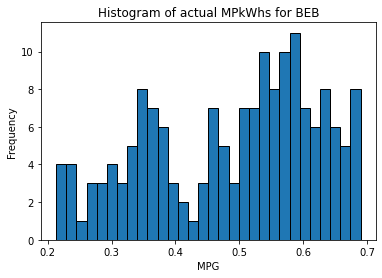

In [74]:
plt.hist(trimmed_validation_beb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPkWhs for BEB')
plt.show()

In [77]:
from sklearn.model_selection import train_test_split

train_merged_df, test_merged_df = train_test_split(trimmed_validation_beb, test_size=0.2, random_state=42)

In [76]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_merged_df['trip'], test_merged_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_merged_df['trip'], test_merged_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.31
RMSE: 64.45


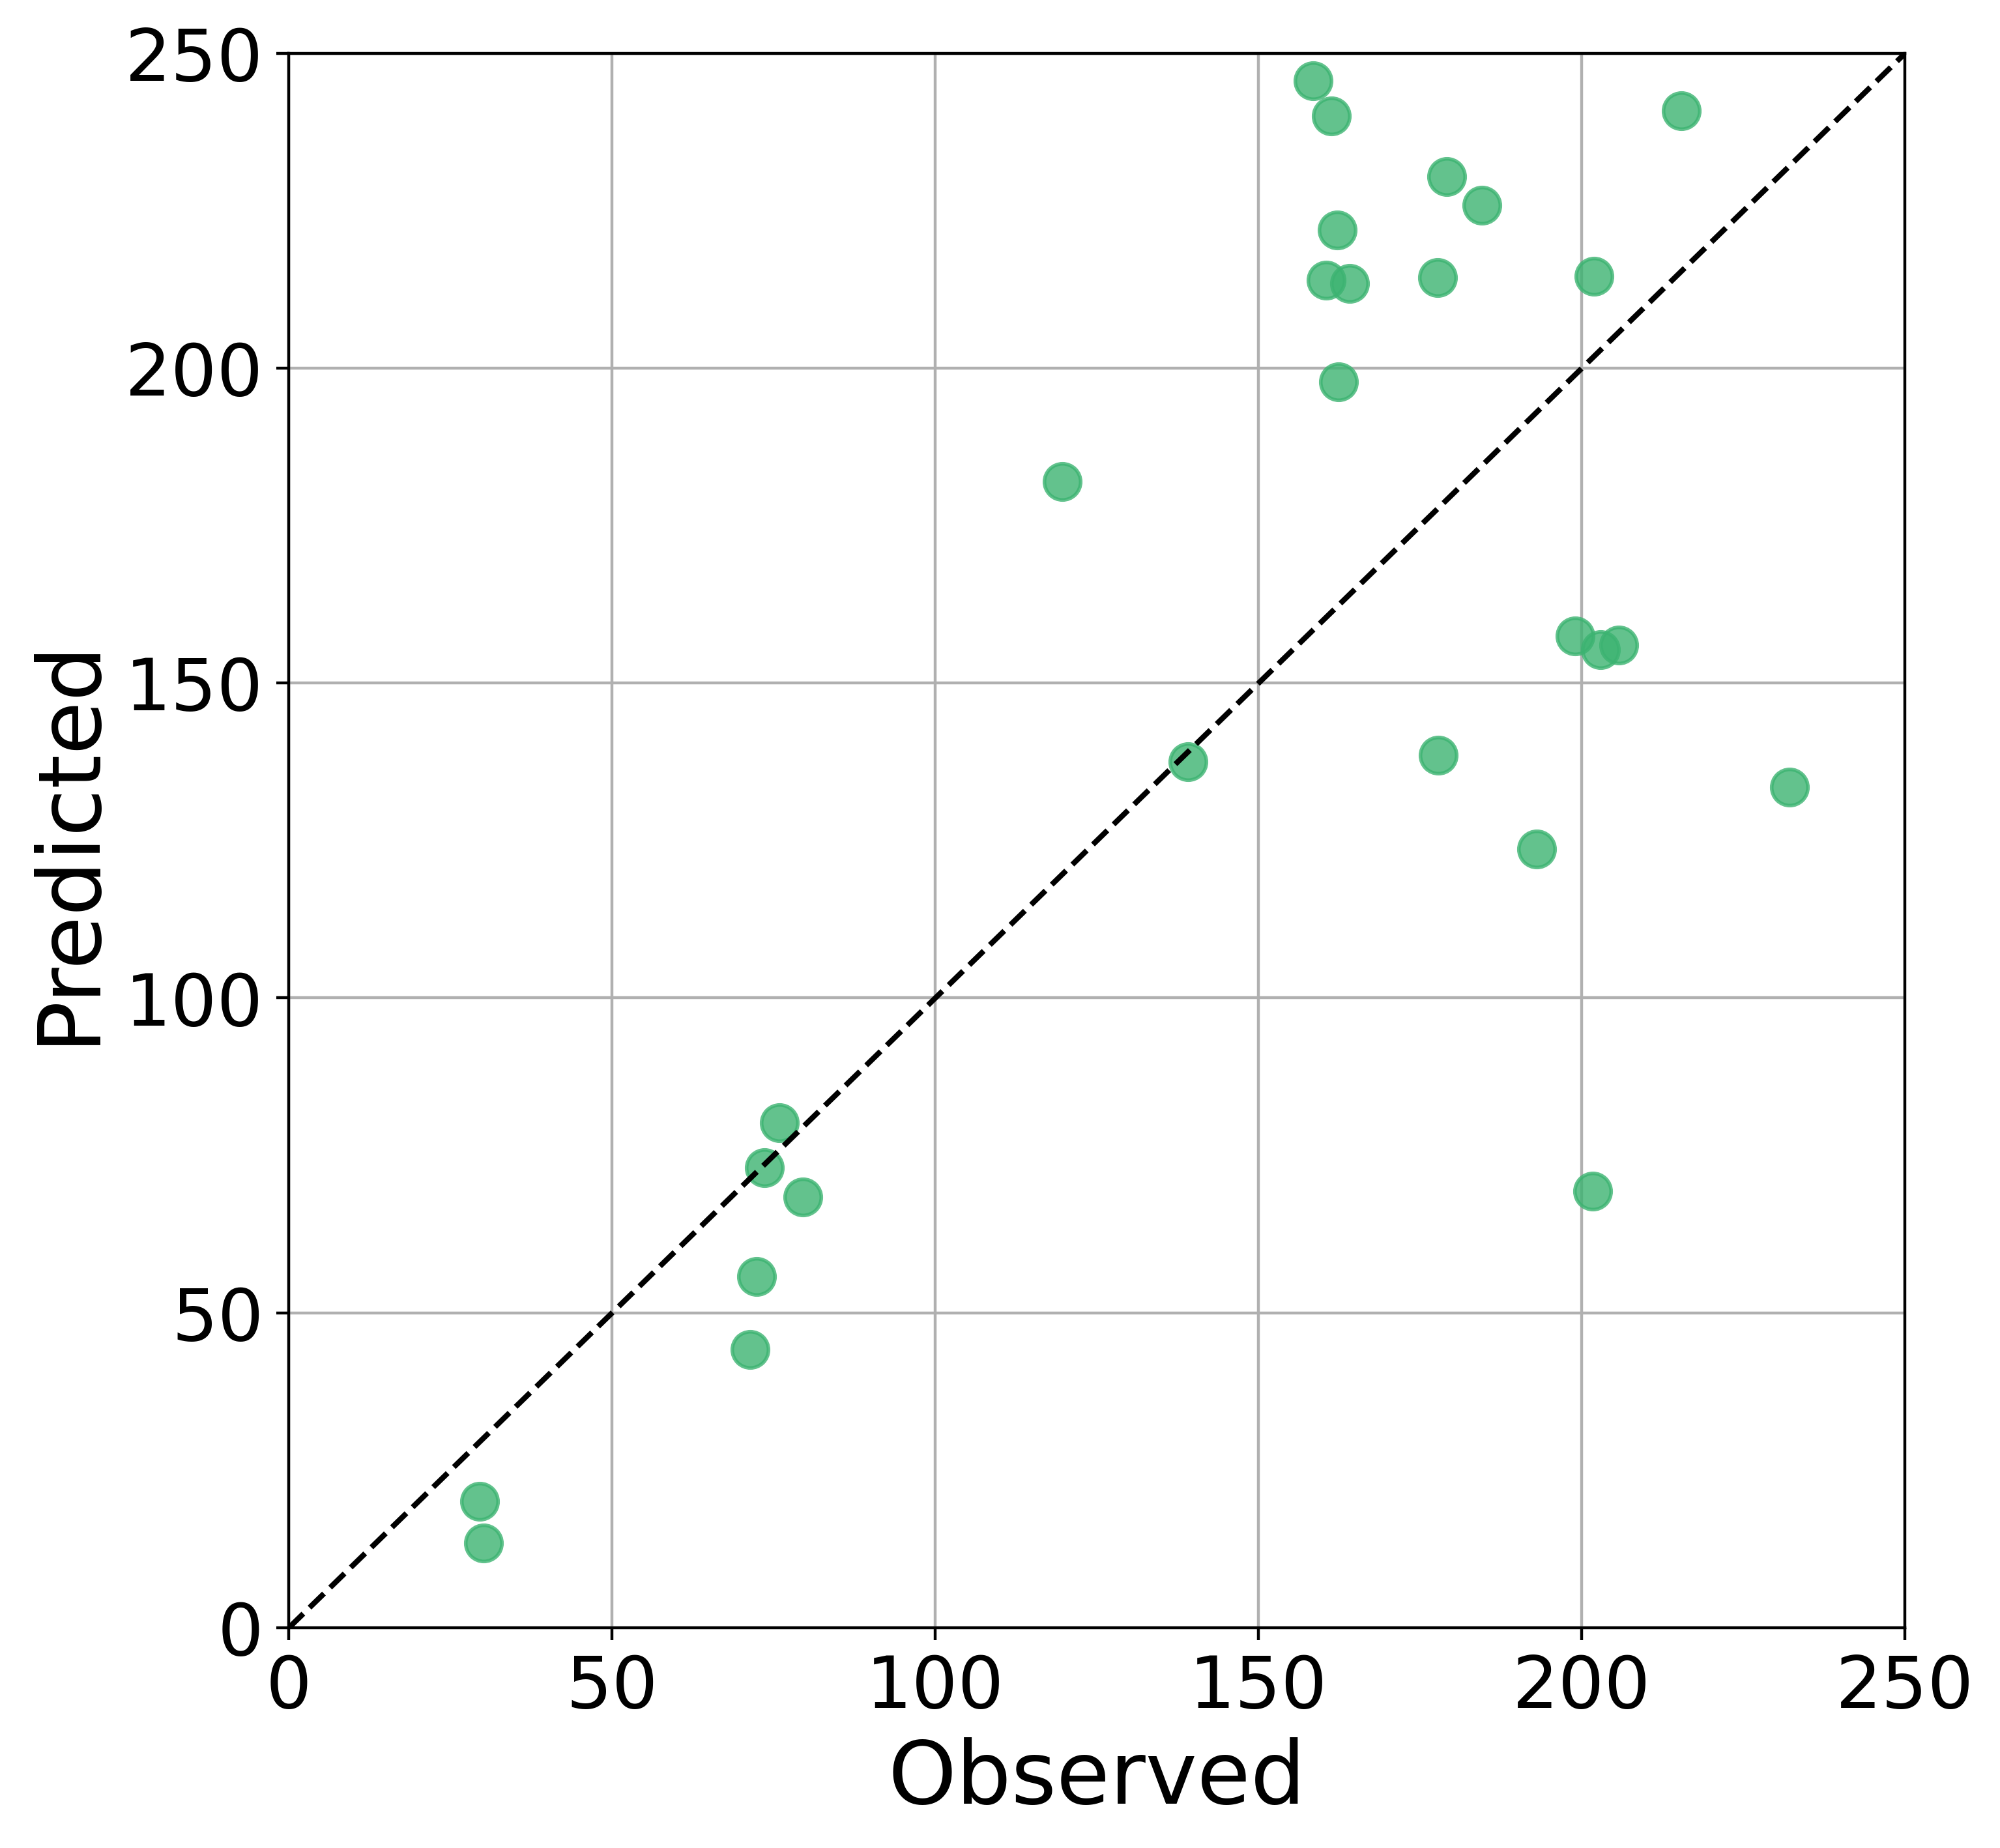

In [79]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(test_merged_df['trip'], test_merged_df['Energy'], alpha=0.8, s=100, color='mediumseagreen', zorder=2)

# Calculate the minimum and maximum limits for x and y axes
xlim = ylim = (0, 250)
xy_min = min(xlim[0], ylim[0])
xy_max = max(xlim[1], ylim[1])

# add a reference line showing perfect agreement between predicted and observed values
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='black', linestyle='dashed', zorder=2)

# set the axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# set the axis labels
plt.ylabel('Predicted', fontsize=24)
plt.xlabel('Observed', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding gridlines to the plot
plt.grid(True, zorder=1)

# show the plot
plt.show()

# Saving
fig.savefig(r'../../figures/BEB-observed-vs-predicted-sep2021-oct2022.png', dpi=400, bbox_inches='tight')

In [80]:
test_merged_df

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
232          1420  228.1     1.0       2022-09-13 2022-09-13   1420.0   
192          1321   30.1     0.0       2022-06-17 2022-06-17   1321.0   
222          1420  181.4     0.8       2022-09-01 2022-09-01   1420.0   
76           1420  189.3   340.4       2022-08-17 2022-08-17   1420.0   
161          1421  232.1     0.0       2022-06-10 2022-06-10   1421.0   
36           3501  179.1   118.3       2022-08-11 2022-08-11   3501.0   
265          1321  292.4     0.5       2022-09-22 2022-09-22   1321.0   
71           1421  201.7     0.7       2022-08-05 2022-08-05   1421.0   
170          1421  215.4     1.0       2022-06-21 2022-06-21   1421.0   
244          1420  160.4   219.2       2022-09-27 2022-09-27   1420.0   
23           3501  164.1   181.4       2022-07-01 2022-07-01   3501.0   
143          1322   75.9    13.7       2022-07-14 2022-07-14   1322.0   
19           3501  199.0    88.8       2022-06-27 2022-06-27   3501.0   
97           1322  201.9    73.1       2022-08-08 2022-08-08   1322.0   
29           3501  214.8   320.6       2022-08-03 2022-08-03   3501.0   
37           3501  177.8   220.1       2022-08-12 2022-08-12   3501.0   
223          1420   79.5   386.9       2022-09-02 2022-09-02   1420.0   
177          1421   73.6     0.0       2022-06-29 2022-06-29   1421.0   
257          1321  184.5     0.2       2022-09-13 2022-09-13   1321.0   
20           3501  158.4   345.9       2022-06-28 2022-06-28   3501.0   
125          1421  162.2     0.3       2022-07-20 2022-07-20   1421.0   
22           3501  119.6   195.6       2022-06-30 2022-06-30   3501.0   
15           3501  202.9    99.2       2022-06-22 2022-06-22   3501.0   
11           3501  205.7   101.2       2022-06-15 2022-06-15   3501.0   
39           3501  233.4     0.0       2022-08-15 2022-08-15   3501.0   
260          1321   72.3   172.3       2022-09-16 2022-09-16   1321.0   
164          1421   29.5   389.6       2022-06-15 2022-06-15   1421.0   
78           1420  193.0    73.3       2022-08-19 2022-08-19   1420.0   
231          1420  177.7   248.2       2022-09-12 2022-09-12   1420.0   
270          1321  139.1   390.0       2022-09-27 2022-09-27   1321.0   
236          1420   71.3   314.0       2022-09-19 2022-09-19   1420.0   
129          1421  161.3    64.5       2022-07-27 2022-07-27   1421.0   
87           1420  162.4     0.7       2022-08-29 2022-08-29   1420.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
232  370.002505  143.890624    0.630823  0.388891  62.210655  
192   13.466671    7.966788    0.264677  0.591593  55.260231  
222  261.052142  106.042993    0.584581  0.406214  43.909670  
76   263.821787  119.955034    0.633677  0.454682  39.367029  
161  133.431596   72.740585    0.313402  0.545153  42.511161  
36   230.393549   91.517109    0.510983  0.397221  28.639614  
265  363.693428  165.532568    0.566117  0.455143  24.382157  
71    69.327720   56.042432    0.277850  0.808370  65.628300  
170  240.917116  117.414314    0.545099  0.487364  11.846386  
244  213.961485   93.319484    0.581792  0.436151  33.392447  
23   213.481978   97.576880    0.594618  0.457073  30.092613  
143   80.186702   41.419885    0.545717  0.516543   5.647828  
19   157.471164   70.493336    0.354238  0.447659  20.868762  
97   214.641011  106.604880    0.528008  0.496666   6.310555  
29   363.379860  135.687219    0.631691  0.373403  69.171257  
37   138.551307   60.762594    0.341747  0.438557  22.074630  
223   68.437552   36.204150    0.455398  0.529010  13.915029  
177   73.027518   37.057945    0.503505  0.507452   0.777829  
257  225.834443  124.681304    0.675779  0.552092  22.403492  
20   245.637460   94.462516    0.596354  0.384561  55.074154  
125  221.902338  103.142561    0.635897  0.464811  36.807853  
22   181.969650   68.780002    0.575084  0.377975  52.148537  
15   155.279471   70.551210    0.347714  0.454350  23.469950  
11   156.0

In [78]:
# Calculate Absolute Percentage Error (APE) for each row
trimmed_validation_beb['APE'] = (abs(trimmed_validation_beb['trip'] - trimmed_validation_beb['Energy']) / trimmed_validation_beb['trip']) * 100
top_20_mape = trimmed_validation_beb.nlargest(20, 'APE')
top_20_mape

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_21860\2020000659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_validation_beb['APE'] = (abs(trimmed_validation_beb['trip'] - trimmed_validation_beb['Energy']) / trimmed_validation_beb['trip']) * 100


Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
59           1323   40.5     0.0       2022-04-14 2022-04-14   1323.0   
215          1321   46.5     0.0       2022-05-20 2022-05-20   1321.0   
64           1323   23.0    22.0       2022-04-25 2022-04-25   1323.0   
180          1321   62.4     0.0       2022-06-02 2022-06-02   1321.0   
187          1321   18.8     0.0       2022-06-10 2022-06-10   1321.0   
29           3501  214.8   320.6       2022-08-03 2022-08-03   3501.0   
114          1421  234.0    84.9       2022-07-08 2022-07-08   1421.0   
44           3501  213.0   351.1       2022-08-24 2022-08-24   3501.0   
71           1421  201.7     0.7       2022-08-05 2022-08-05   1421.0   
83           1420  180.8     1.3       2022-08-25 2022-08-25   1420.0   
216          1321   42.7   139.7       2022-05-23 2022-05-23   1321.0   
25           3501  215.8   233.1       2022-07-05 2022-07-05   3501.0   
136          1322  191.6   319.3       2022-07-07 2022-07-07   1322.0   
16           3501   65.8   198.9       2022-06-23 2022-06-23   3501.0   
246          1420  192.1   222.2       2022-09-29 2022-09-29   1420.0   
232          1420  228.1     1.0       2022-09-13 2022-09-13   1420.0   
181          1321   20.4    73.1       2022-06-03 2022-06-03   1321.0   
182          1321   73.1     0.0       2022-06-04 2022-06-04   1321.0   
208          1321   20.2     0.0       2022-05-11 2022-05-11   1321.0   
62           1323  160.7    78.3       2022-04-19 2022-04-19   1323.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
59     6.412037    9.528018    0.235260  1.485958  84.167810  
215    9.551027   10.272495    0.220914  1.075538  79.460157  
64     4.914100    6.098154    0.265137  1.240950  78.634347  
180   14.461254   15.230013    0.244071  1.053160  76.824914  
187    5.243280    4.440169    0.236179  0.846830  72.110213  
29   363.379860  135.687219    0.631691  0.373403  69.171257  
114  393.867277  154.876640    0.661866  0.393220  68.319349  
44   354.926561  136.375855    0.640262  0.384237  66.632188  
71    69.327720   56.042432    0.277850  0.808370  65.628300  
83    62.816083   51.784133    0.286417  0.824377  65.256591  
216   15.044975    9.114973    0.213465  0.605848  64.765867  
25   355.055351  133.692758    0.619522  0.376541  64.529820  
136   68.550251   58.168329    0.303593  0.848550  64.222207  
16   107.827988   43.645811    0.663310  0.404773  63.872322  
246  313.235038  126.959878    0.660905  0.405318  63.058323  
232  370.002505  143.890624    0.630823  0.388891  62.210655  
181    7.914981    6.934327    0.339918  0.876102  61.201075  
182   28.605061   17.363505    0.237531  0.607008  60.868589  
208    8.251366    6.934327    0.343284  0.840385  59.151655  
62    66.856426   41.319387    0.257121  0.618032  58.396748

In [53]:
trimmed_validation_beb

Equipment ID   trip  charge Transaction Date       Date  Vehicle  \
0            3501   26.7    35.0       2022-06-01 2022-06-01   3501.0   
1            3501  167.1   182.7       2022-06-02 2022-06-02   3501.0   
3            3501  173.9   166.1       2022-06-06 2022-06-06   3501.0   
4            3501   74.3   180.0       2022-06-07 2022-06-07   3501.0   
5            3501   81.4   108.5       2022-06-08 2022-06-08   3501.0   
..            ...    ...     ...              ...        ...      ...   
269          1321  141.5     0.8       2022-09-26 2022-09-26   1321.0   
270          1321  139.1   390.0       2022-09-27 2022-09-27   1321.0   
271          1321  194.8     3.1       2022-09-28 2022-09-28   1321.0   
272          1321  116.0   387.8       2022-09-29 2022-09-29   1321.0   
273          1321  193.6     0.9       2022-09-30 2022-09-30   1321.0   

         Energy        dist  actual_mpg  pred_mpg        APE  
0     33.734389   15.759902    0.590259  0.467176  26.346027  
1    219.520662   96.860943    0.579659  0.441238  31.370833  
3    212.339484   97.573532    0.561090  0.459517  22.104361  
4    117.440518   44.192232    0.594781  0.376295  58.062608  
5    100.004826   43.615372    0.535815  0.436133  22.856052  
..          ...         ...         ...       ...        ...  
269  178.071729   88.931381    0.628490  0.499413  25.845745  
270  137.503337   63.968701    0.459876  0.465216   1.147852  
271  195.651297  102.720630    0.527313  0.525019   0.437011  
272   79.697589   42.246626    0.364195  0.530087  31.295182  
273  181.901215  100.532695    0.519280  0.552677   6.042761  

[165 rows x 11 columns]

In [54]:
trimmed_validation_beb['Transaction Date'] = pd.to_datetime(trimmed_validation_beb['Transaction Date'])
trimmed_validation_beb = trimmed_validation_beb.set_index('Transaction Date')
trimmed_validation_beb = trimmed_validation_beb[['Energy','trip']].resample('W').sum()
trimmed_validation_beb = trimmed_validation_beb.reset_index()

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_21860\1077121597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_validation_beb['Transaction Date'] = pd.to_datetime(trimmed_validation_beb['Transaction Date'])


In [55]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
train_merged_df, test_merged_df = train_test_split(trimmed_validation_beb, test_size=0.2, random_state=42)

In [56]:
test_merged_df

Transaction Date       Energy    trip
8        2022-06-12  1191.754245  1248.2
16       2022-08-07  1853.672665  1864.7
0        2022-04-17   320.004300   346.9
23       2022-09-25  1438.722643  1123.7
11       2022-07-03  1112.328805   929.6

In [57]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_merged_df['trip'], test_merged_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_merged_df['trip'], test_merged_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.12
RMSE: 165.32


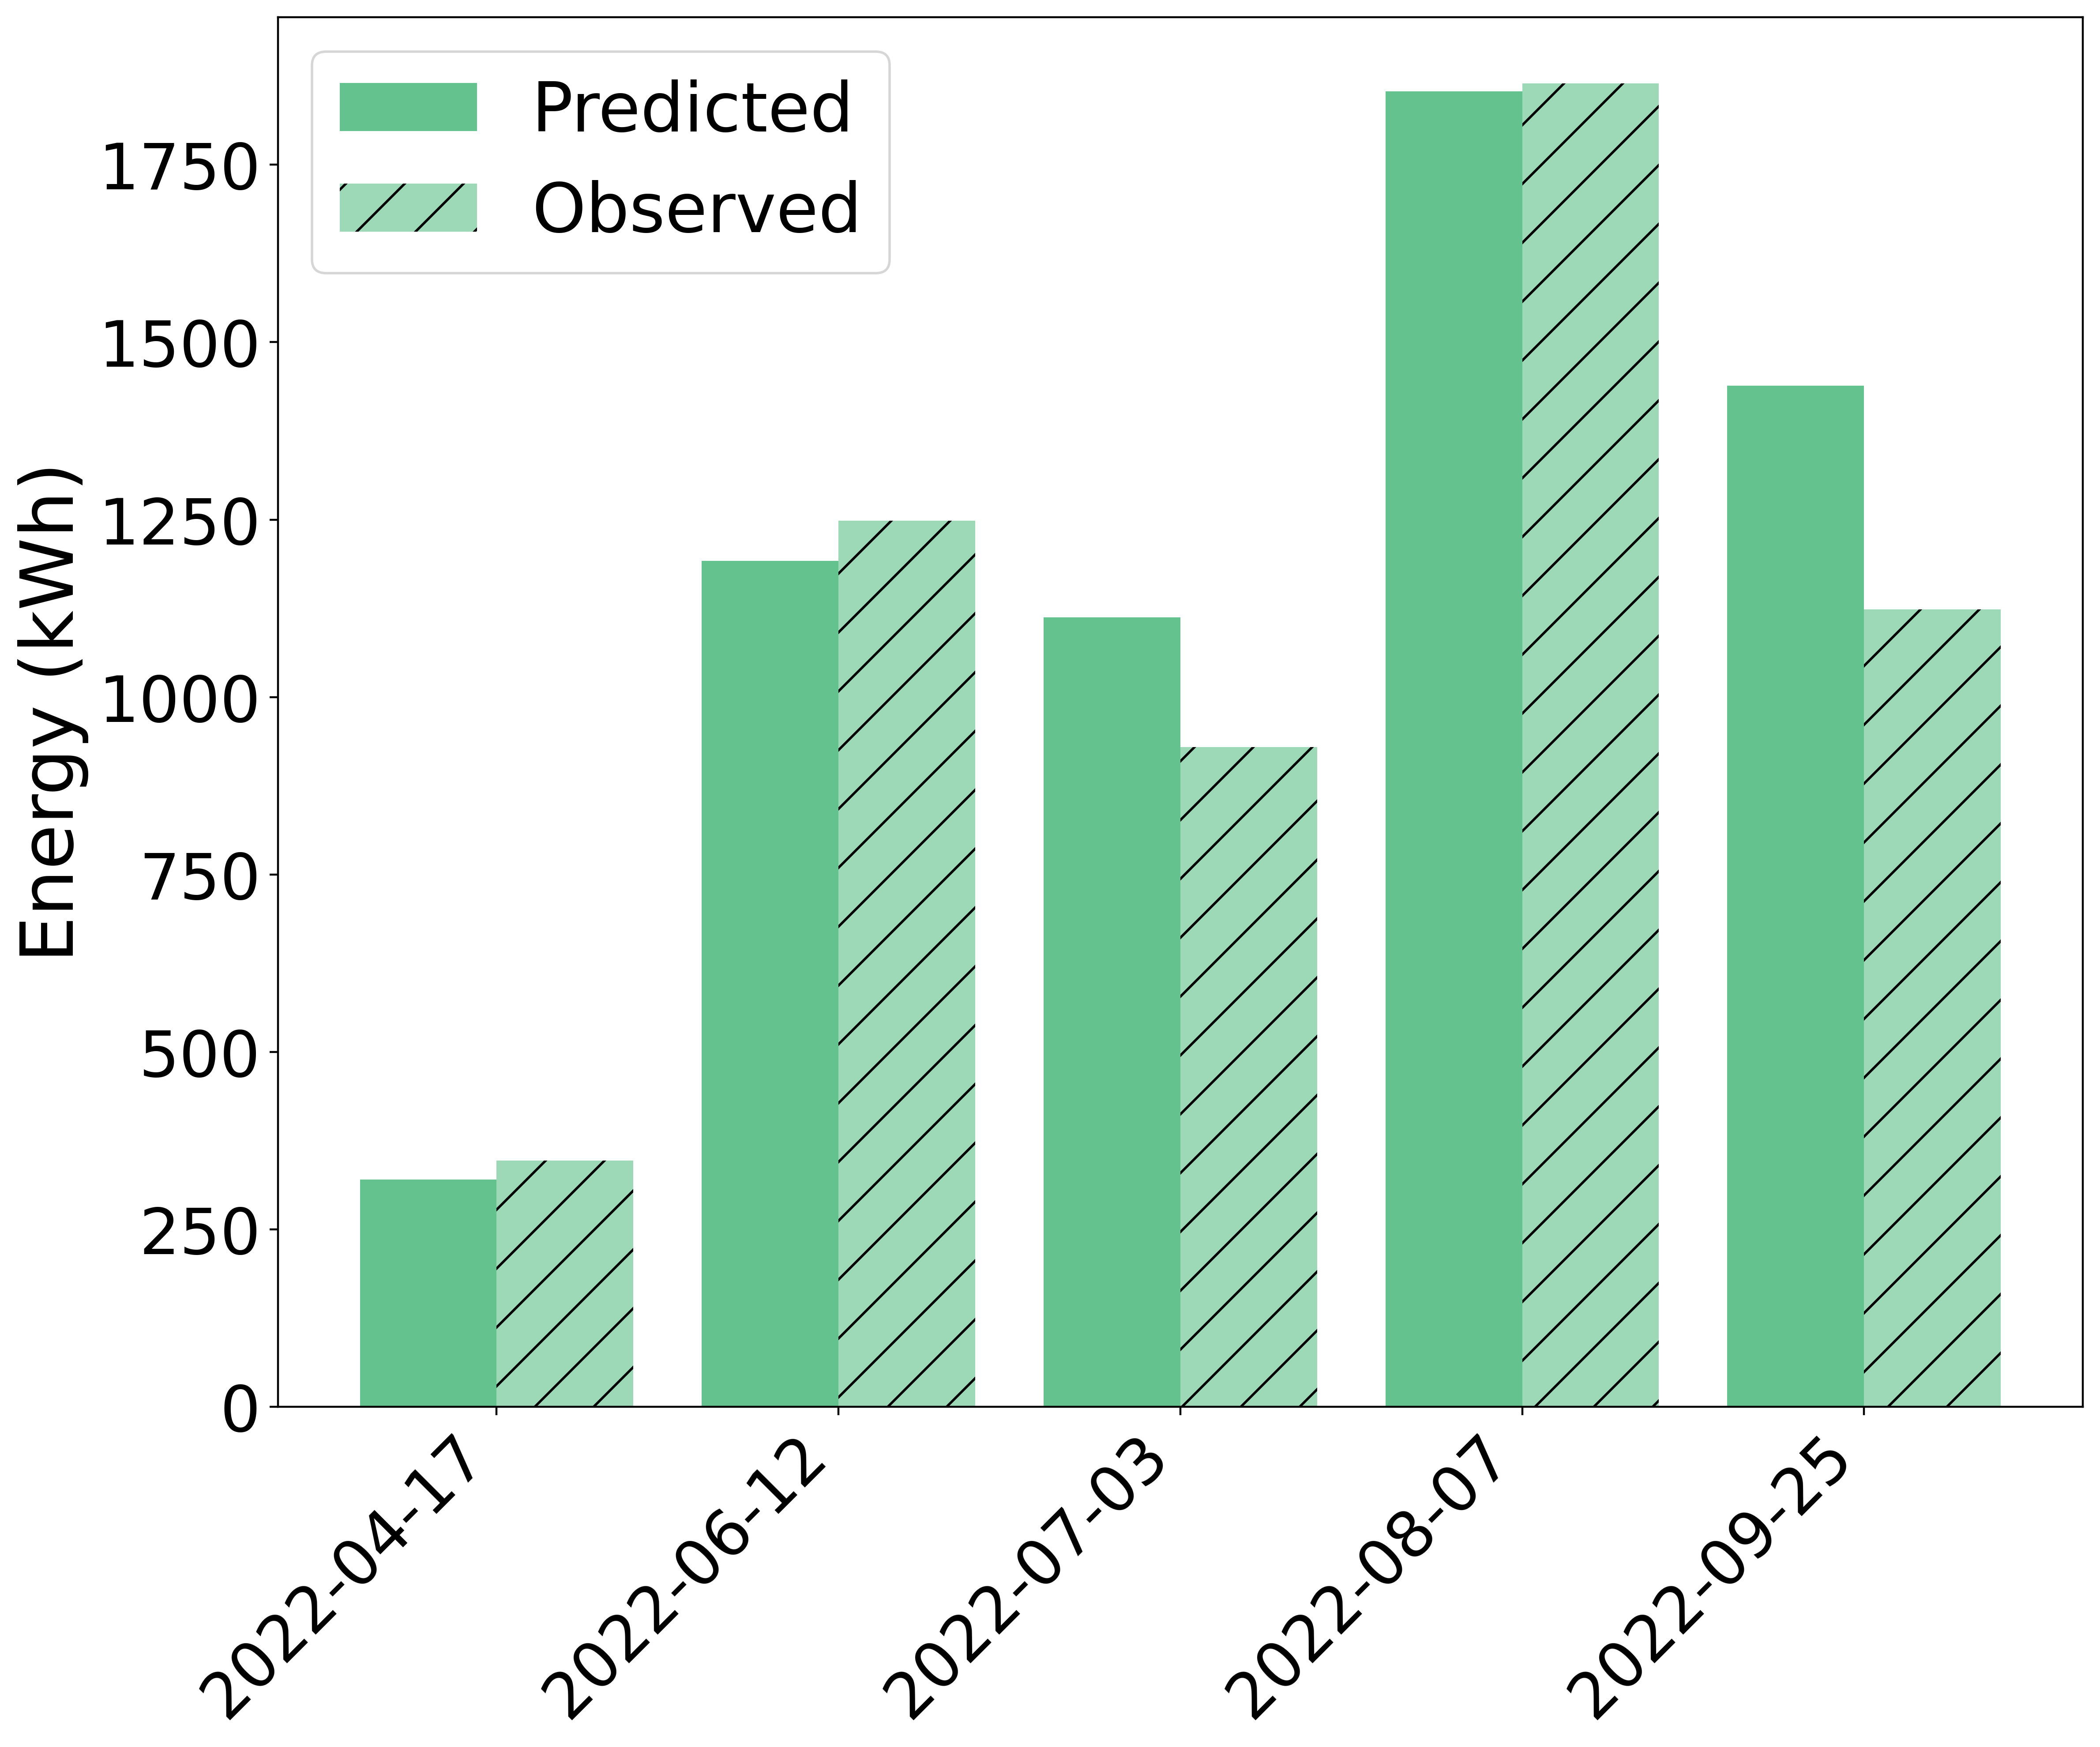

In [58]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ServiceDateTime' is a datetime object
test_merged_df['Transaction Date'] = pd.to_datetime(test_merged_df['Transaction Date'])
test_merged_df = test_merged_df.sort_values('Transaction Date')


# Set 'ServiceDateTime' as index for plotting purposes
test_merged_df.set_index('Transaction Date', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_merged_df))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_merged_df['Energy'], width=bar_width, color='mediumseagreen', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_merged_df['trip'], width=bar_width, color='mediumseagreen', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_merged_df.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (kWh)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout() 

# Save the figure with high resolution
plt.savefig(r'../../figures/weekly-BEB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()


### HEB

In [141]:
validation_heb = pd.read_csv(r'../../results/validation-vs-computed-fuel-rates-clean-heb-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

In [142]:
validation_heb['actual_mpg']=validation_heb['dist']/validation_heb['Qty']
validation_heb['pred_mpg']=validation_heb['dist']/validation_heb['Energy']

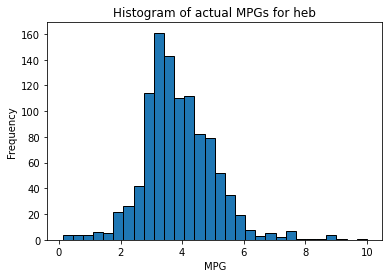

In [143]:
plt.hist(validation_heb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for heb')
plt.show()

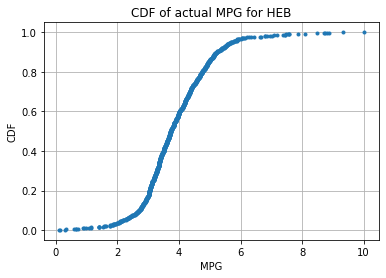

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df['actual_mpg'] contains your data
data = validation_heb['actual_mpg']

# Calculate the CDF values
data_sorted = np.sort(data)
cdf = np.arange(1, len(data_sorted)+1) / len(data_sorted)

# Create a CDF plot
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('MPG')
plt.ylabel('CDF')
plt.title('CDF of actual MPG for HEB')
plt.grid(True)
plt.show()


In [145]:
# Calculate the 1st and 99th percentiles
percentile_5 = validation_heb['actual_mpg'].quantile(0.05)
percentile_95 = validation_heb['actual_mpg'].quantile(0.95)

# Filter the DataFrame
#trimmed_validation_heb = validation_heb[(validation_heb['pred_mpg'] >= percentile_5) & (validation_heb['pred_mpg'] <= percentile_95)]
#trimmed_validation_heb = trimmed_validation_heb[(trimmed_validation_heb['actual_mpg'] >= percentile_5) & (trimmed_validation_heb['actual_mpg'] <= percentile_95)]
trimmed_validation_heb = validation_heb[(validation_heb['actual_mpg'] >= percentile_5) & (validation_heb['actual_mpg'] <= percentile_95)]

In [146]:
train_df_heb_vehicle, test_df_heb_vehicle = train_test_split(trimmed_validation_heb, test_size=0.2, random_state=42)

In [147]:
# Compute MAPE
mape = mean_absolute_percentage_error(test_df_heb_vehicle['Qty'], test_df_heb_vehicle['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_heb_vehicle['Qty'], test_df_heb_vehicle['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.24
RMSE: 8.98


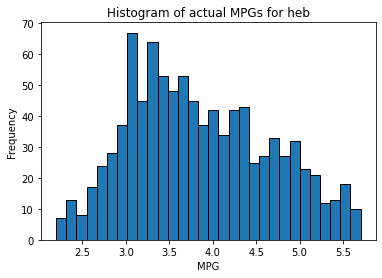

In [148]:
plt.hist(trimmed_validation_heb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for heb')
plt.show()

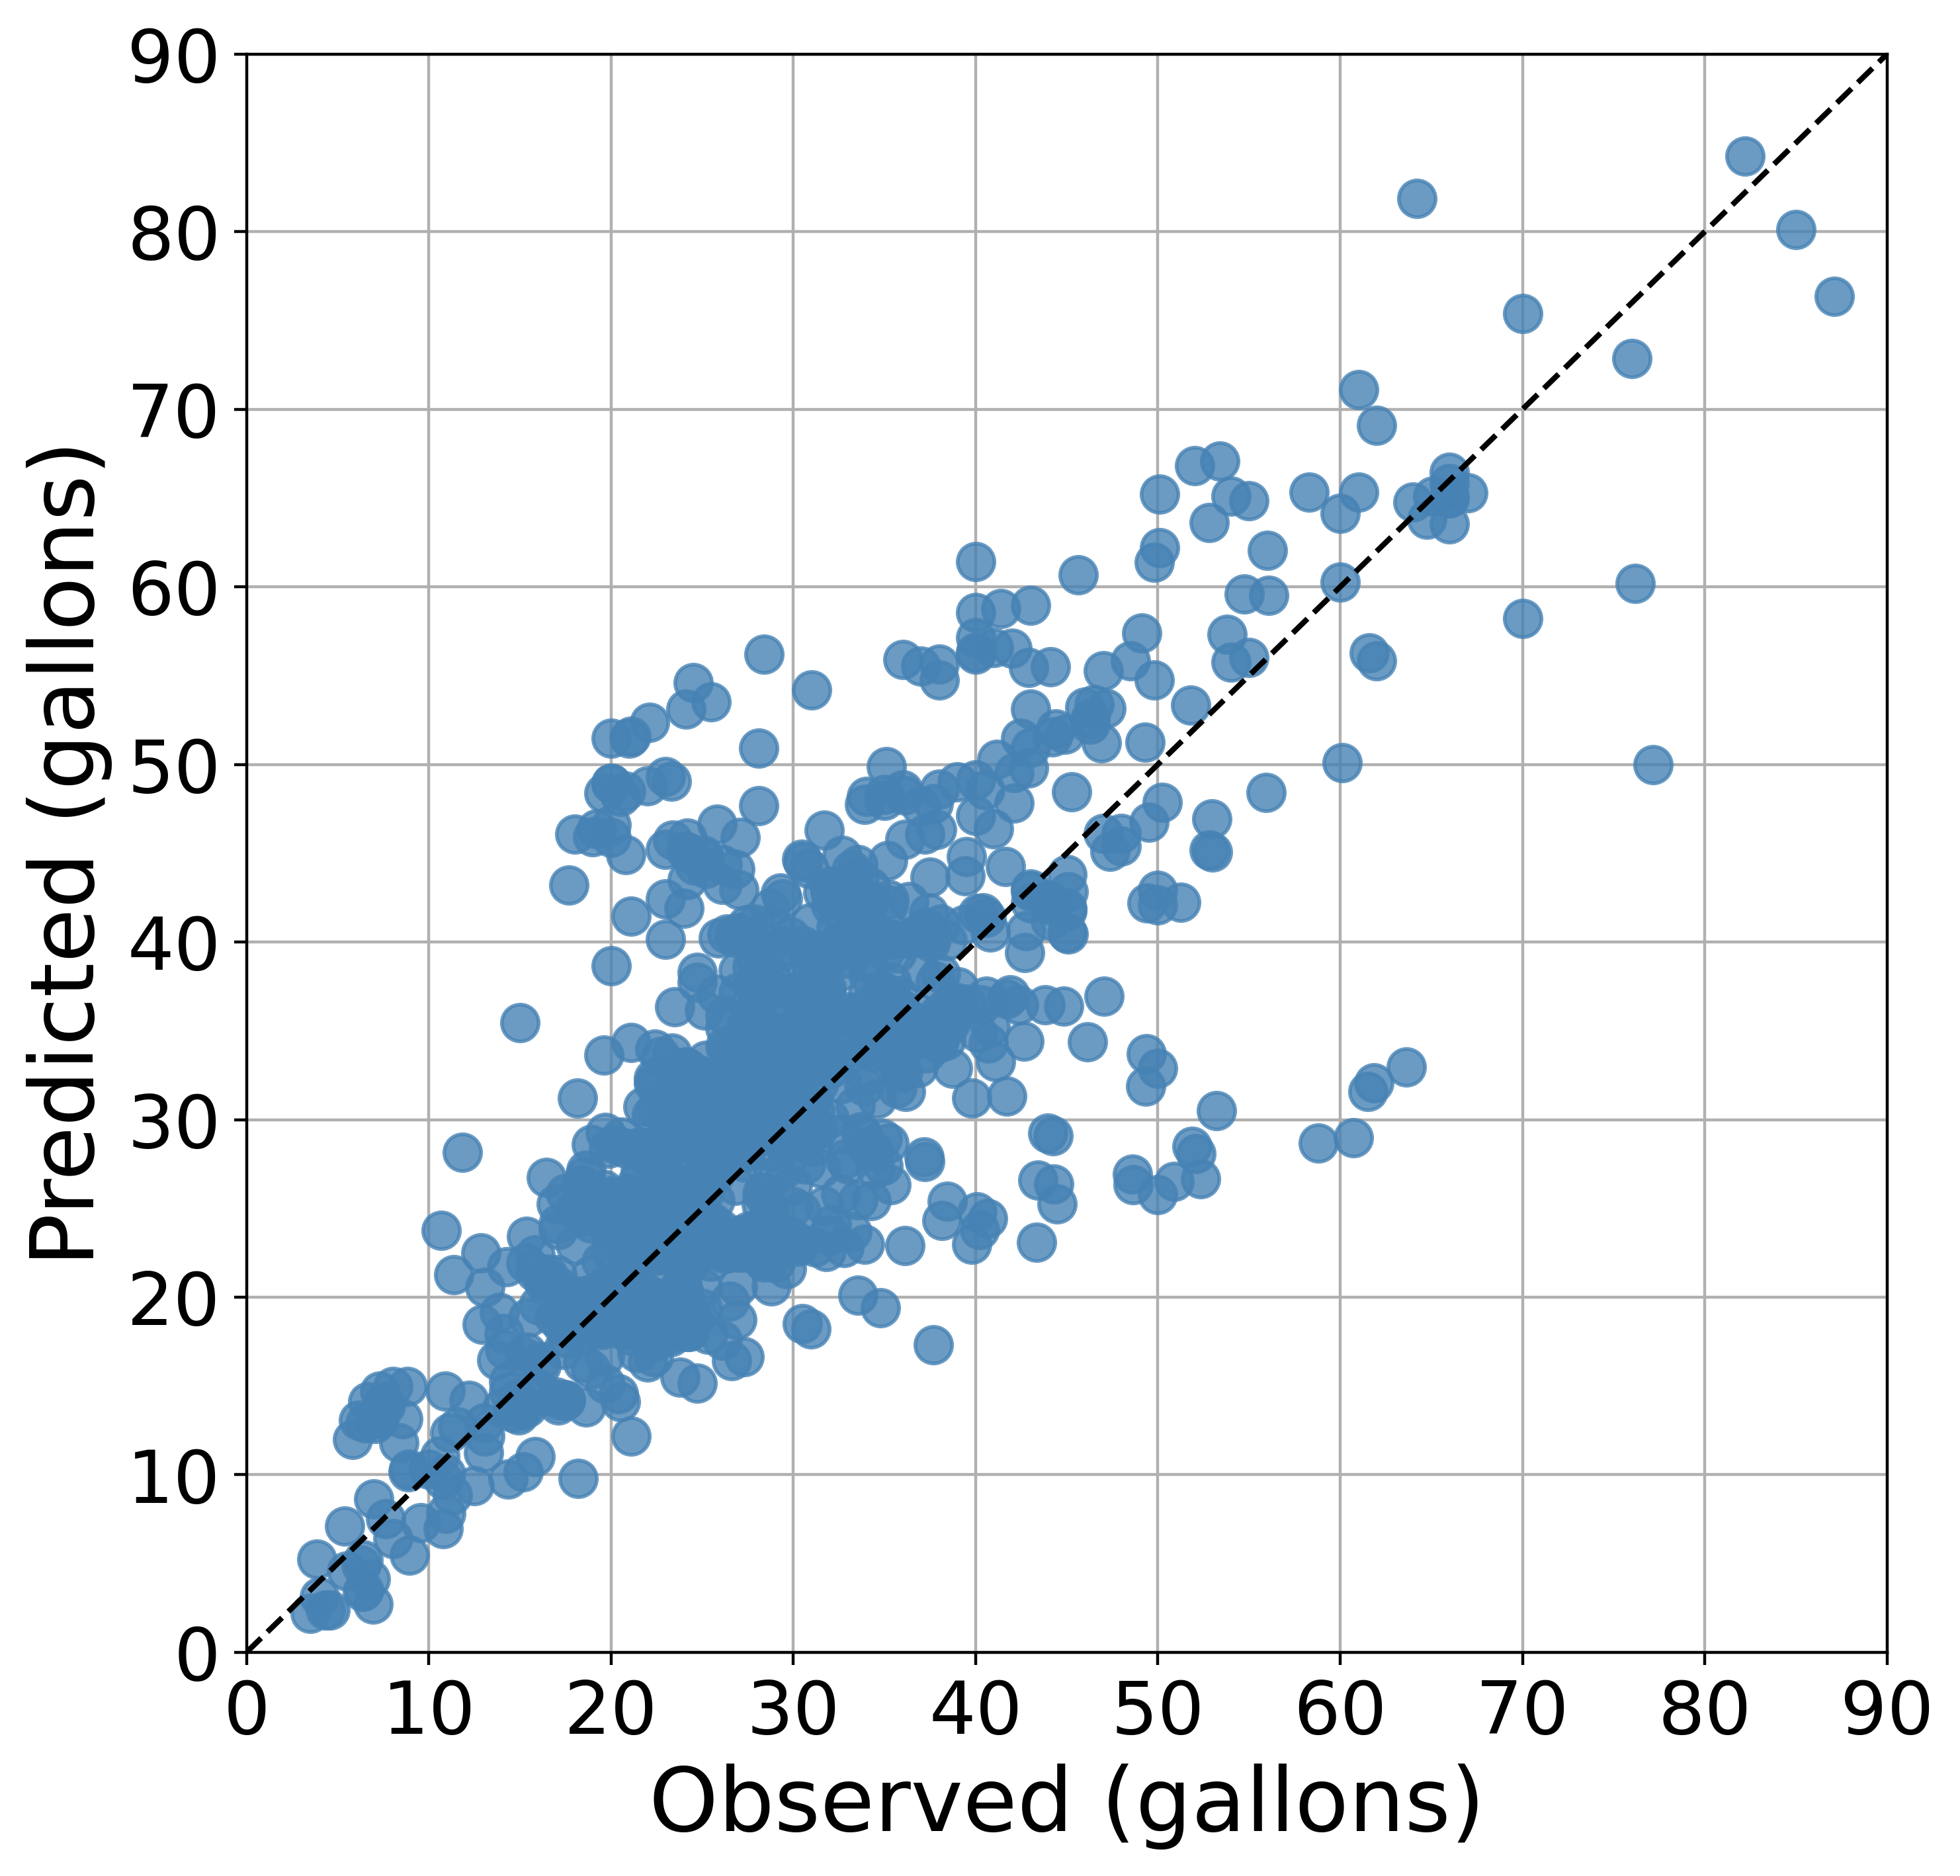

In [203]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(trimmed_validation_heb['Qty'], trimmed_validation_heb['Energy'], alpha=0.8, s=100, color='steelblue', zorder=2)

# set the axis limits to 90
xlim = ylim = (0, 90)
plt.xlim(xlim)
plt.ylim(ylim)


# add a reference line showing perfect agreement between predicted and observed values
plt.plot(xlim, ylim, color='black', linestyle='dashed', zorder=2)

# set the axis labels
plt.ylabel('Predicted (gallons)', fontsize=24)
plt.xlabel('Observed (gallons)', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding gridlines to the plot
plt.grid(True, zorder=1)

# show the plot
plt.show()

In [150]:
trimmed_validation_heb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_heb['ServiceDateTime'])
trimmed_validation_heb = trimmed_validation_heb.set_index('ServiceDateTime')
weekly_energy_heb = trimmed_validation_heb[['Energy','Qty']].resample('W').sum()
weekly_energy_heb=weekly_energy_heb.reset_index()

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_19064\714379725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_validation_heb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_heb['ServiceDateTime'])


In [151]:
train_df_heb_system, test_df_heb_system = train_test_split(weekly_energy_heb, test_size=0.2, random_state=42)

In [152]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_df_heb_system['Qty'], test_df_heb_system['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_heb_system['Qty'], test_df_heb_system['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.08
RMSE: 63.84


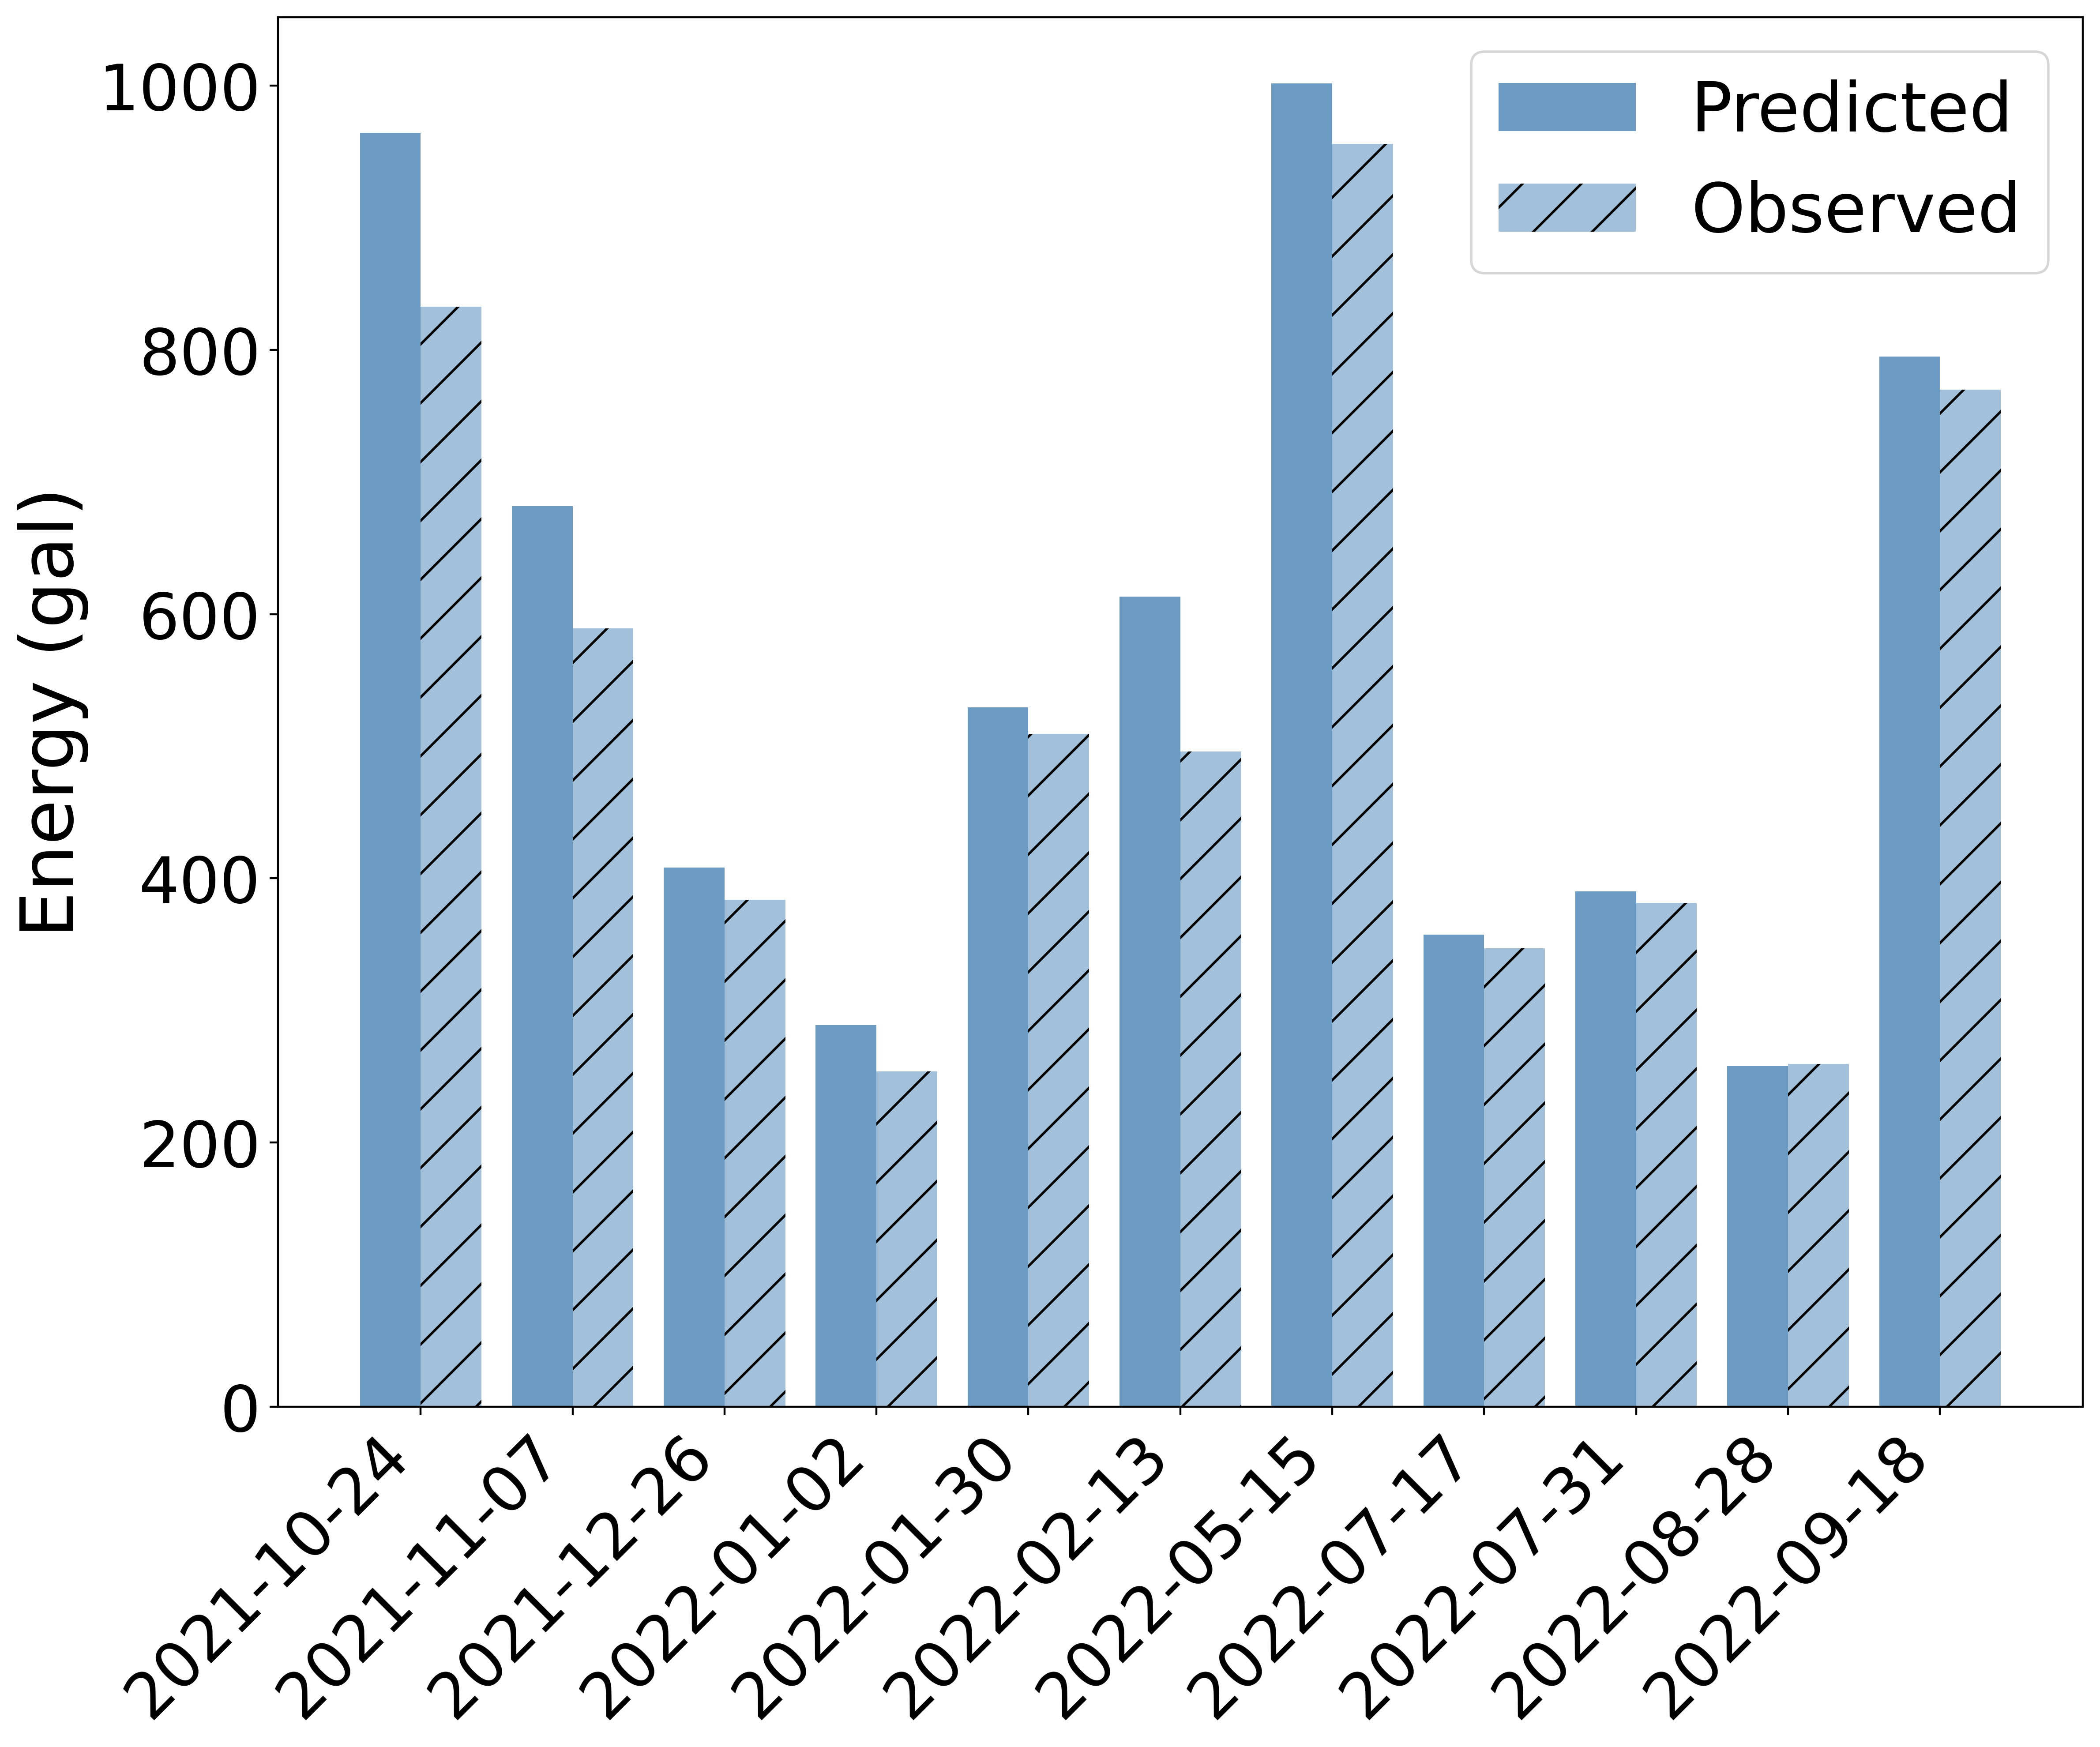

In [153]:
# Ensure 'ServiceDateTime' is a datetime object
test_df_heb_system['ServiceDateTime'] = pd.to_datetime(test_df_heb_system['ServiceDateTime'])
test_df_heb_system = test_df_heb_system.sort_values('ServiceDateTime')


# Set 'ServiceDateTime' as index for plotting purposes
test_df_heb_system.set_index('ServiceDateTime', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_df_heb_system))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_df_heb_system['Energy'], width=bar_width, color='steelblue', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_df_heb_system['Qty'], width=bar_width, color='steelblue', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_df_heb_system.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (gal)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout()

# Save the figure with high resolution
plt.savefig(r'../../figures/validation-HEB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()


### CDB

In [154]:
validation_cdb = pd.read_csv(r'../../results/validation-vs-computed-fuel-rates-clean-cdb-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

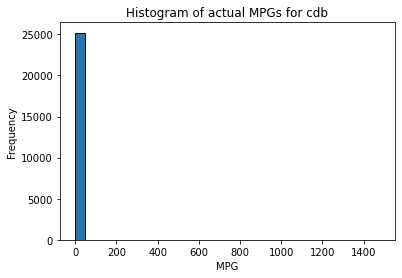

In [155]:
validation_cdb['actual_mpg']=validation_cdb['dist']/validation_cdb['Qty']
validation_cdb['pred_mpg']=validation_cdb['dist']/validation_cdb['Energy']
plt.hist(validation_cdb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for cdb')
plt.show()

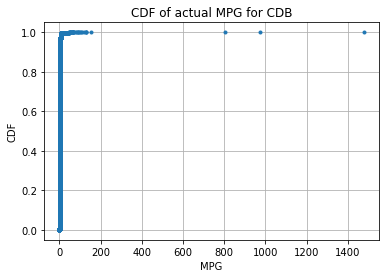

In [156]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming merged_df['actual_mpg'] contains your data
data = validation_cdb['actual_mpg']

# Calculate the CDF values
data_sorted = np.sort(data)
cdf = np.arange(1, len(data_sorted)+1) / len(data_sorted)

# Create a CDF plot
plt.plot(data_sorted, cdf, marker='.', linestyle='none')
plt.xlabel('MPG')
plt.ylabel('CDF')
plt.title('CDF of actual MPG for CDB')
plt.grid(True)
plt.show()


In [157]:
top_10_rows = validation_cdb.nlargest(20, 'actual_mpg')
top_10_rows

Unnamed: 0  index  Vehicle   Qty      ServiceDateTime  Meter1Reading  \
4110         4313   5962     1644  0.05  2022-01-18 22:06:00              0   
505           527   5165     1555  0.06  2022-01-18 16:41:00         355495   
3608         3766   4700     1619  0.04  2022-01-19 15:52:00              0   
15711       16399  13993     1835  2.50  2022-01-19 16:26:00              0   
23519       24560   1350     7802  1.20  2021-12-10 06:21:00         396874   
23509       24548   1338     7802  1.50  2021-11-29 05:55:00         395311   
4088         4284   5933     1644  0.68  2021-10-27 20:53:00         359880   
24788       25862   2351     7815  1.20  2022-02-21 07:58:00         338325   
22535       23541     90     7610  1.20  2022-03-11 20:55:00         511675   
24465       25530   2083     7814  1.00  2021-10-29 17:32:00         350558   
23538       24580   1370     7802  1.40  2022-01-13 05:36:00         399080   
22634       23643    498     7660  1.00  2021-12-14 16:09:00         499365   
21992       22980   2792     7553  1.00  2022-01-20 18:39:00          55994   
24471       25537   2090     7814  1.20  2021-11-05 18:00:00         351434   
21770       22750   1002     7552  1.70  2021-12-21 20:01:00         344243   
20450       21376  21127     1860  1.39  2022-01-14 16:12:00          28537   
4889         5151   8742     1652  0.88  2021-11-22 18:55:00              0   
2559         2666   7869     1573  1.83  2022-05-16 18:17:00         337347   
12765       13311  11011     1814  1.98  2021-11-23 19:08:00              0   
4098         4296   5945     1644  2.28  2021-12-03 19:36:00         361575   

      Fuel Orfluid Type    Powertrain        dist      Energy   actual_mpg  \
4110                DIE  conventional   73.884031   37.903812  1477.680610   
505                 DIE  conventional   58.393161   21.812658   973.219355   
3608                DIE  conventional   32.114048   20.663357   802.851202   
15711               DIE  conventional  389.332574  130.094999   155.733030   
23519               DIE  conventional  157.402151   62.442781   131.168459   
23509               DIE  conventional  196.568868   68.147508   131.045912   
4088                DIE  conventional   87.118475   32.738015   128.115405   
24788               DIE  conventional  140.476330   45.322030   117.063608   
22535               DIE  conventional  128.840324   34.994306   107.366936   
24465               DIE  conventional  104.639550   32.992146   104.639550   
23538               DIE  conventional  141.457145   46.608666   101.040818   
22634               DIE  conventional   97.334818   27.065230    97.334818   
21992               DIE  conventional   91.492933   30.282199    91.492933   
24471               DIE  conventional  106.514159   35.393125    88.761799   
21770               DIE  conventional  144.313462   38.974158    84.890272   
20450               DIE  conventional  109.243942   39.584254    78.592764   
4889                DIE  conventional   66.643795   16.524775    75.731585   
2559                DIE  conventional  123.447939   35.060284    67.457890   
12765               DIE  conventional  132.720691   41.821439    67.030652   
4098                DIE  conventional  152.776362   34.697295    67.007176   

       pred_mpg  
4110   1.949251  
505    2.677031  
3608   1.554154  
15711  2.992679  
23519  2.520742  
23509  2.884462  
4088   2.661080  
24788  3.099515  
22535  3.681751  
24465  3.171650  
23538  3.034997  
22634  3.596305  
21992  3.021344  
24471  3.009459  
21770  3.702799  
20450  2.759783  
4889   4.032962  
2559   3.521019  
12765  3.173508  
4098   4.403120

In [158]:
# Calculate the 5st and 95th percentiles
percentile_5 = validation_cdb['actual_mpg'].quantile(0.05)
percentile_95 = validation_cdb['actual_mpg'].quantile(0.95)

# Filter the DataFrame
#trimmed_validation_cdb = validation_cdb[(validation_cdb['pred_mpg'] >= percentile_5) & (validation_cdb['pred_mpg'] <= percentile_95)]
#trimmed_validation_cdb = trimmed_validation_cdb[(trimmed_validation_cdb['actual_mpg'] >= percentile_5) & (trimmed_validation_cdb['actual_mpg'] <= percentile_95)]
trimmed_validation_cdb = validation_cdb[(validation_cdb['actual_mpg'] >= percentile_5) & (validation_cdb['actual_mpg'] <= percentile_95)]

In [159]:
top_150_actual_mpg = trimmed_validation_cdb.nlargest(150, 'actual_mpg')
top_150_actual_mpg

Unnamed: 0  index  Vehicle    Qty      ServiceDateTime  Meter1Reading  \
19619       20529  20497     1857  28.56  2022-01-31 20:51:00          30446   
9162         9564  17493     1715  26.79  2022-06-21 15:39:00          88309   
16124       16828  14272     1837  23.64  2021-12-05 20:20:00         249549   
19542       20451  20419     1857  29.14  2021-10-25 19:25:00          18940   
10349       10798  26124     1720  32.20  2022-07-11 19:39:00          80450   
...           ...    ...      ...    ...                  ...            ...   
9146         9548  17477     1715  29.56  2022-05-25 18:43:00          86048   
23280       24309   1157     7801   7.50  2021-12-03 18:10:00         366046   
11198       11669  20393     1723  30.26  2022-06-24 18:48:00          52121   
5067         5338   8880     1653  50.23  2022-02-23 22:35:00         282618   
13139       13704  11313     1816  21.41  2021-10-18 16:45:00         330867   

      Fuel Orfluid Type    Powertrain        dist     Energy  actual_mpg  \
19619               DIE  conventional  137.620844  45.392040    4.818657   
9162                DIE  conventional  129.066725  33.609047    4.817720   
16124               DIE  conventional  113.871725  36.487808    4.816909   
19542               DIE  conventional  140.338607  45.937273    4.816013   
10349               DIE  conventional  155.051199  47.301693    4.815255   
...                 ...           ...         ...        ...         ...   
9146                DIE  conventional  140.154198  42.120427    4.741346   
23280               DIE  conventional   35.558839  11.454451    4.741179   
11198               DIE  conventional  143.467091  45.155143    4.741146   
5067                DIE  conventional  238.145659  69.736959    4.741104   
13139               DIE  conventional  101.497844  33.333826    4.740675   

       pred_mpg  
19619  3.031828  
9162   3.840238  
16124  3.120816  
19542  3.055005  
10349  3.277921  
...         ...  
9146   3.327464  
23280  3.104369  
11198  3.177204  
5067   3.414913  
13139  3.044890  

[150 rows x 12 columns]

In [160]:
low_200_actual_mpg = trimmed_validation_cdb.nsmallest(200, 'actual_mpg')
low_200_actual_mpg

Unnamed: 0  index  Vehicle    Qty      ServiceDateTime  Meter1Reading  \
9986        10409  18046     1719  16.11  2021-11-11 18:05:00          62496   
6202         6504   9770     1660  23.29  2022-04-02 18:05:00         367539   
11053       11521  20245     1723  29.60  2022-01-03 19:38:00          28415   
15382       16033  24748     1833  28.57  2022-08-22 12:50:00         289961   
10823       11282  20083     1722  30.00  2022-02-28 19:44:00          31631   
...           ...    ...      ...    ...                  ...            ...   
9663        10073  25916     1717  19.47  2022-07-05 15:37:00          86165   
1104         1145   6588     1563  36.04  2022-03-28 20:32:00         348165   
5184         5455  23258     1653  35.31  2022-08-08 20:37:00         302188   
13065       13619  11246     1815  32.34  2022-03-16 18:06:00         324618   
5812         6103   9423     1657  34.23  2022-02-15 18:37:00         297625   

      Fuel Orfluid Type    Powertrain       dist     Energy  actual_mpg  \
9986                DIE  conventional  25.218587  18.263103    1.565400   
6202                DIE  conventional  36.464868  18.264163    1.565688   
11053               DIE  conventional  46.398365  17.812725    1.567512   
15382               DIE  conventional  44.786369  12.613212    1.567601   
10823               DIE  conventional  47.028651  18.312429    1.567622   
...                 ...           ...        ...        ...         ...   
9663                DIE  conventional  32.307918  13.502645    1.659369   
1104                DIE  conventional  59.820075  30.052855    1.659825   
5184                DIE  conventional  58.618300  20.227756    1.660105   
13065               DIE  conventional  53.699198  27.143736    1.660458   
5812                DIE  conventional  56.885102  28.264038    1.661849   

       pred_mpg  
9986   1.380849  
6202   1.996526  
11053  2.604788  
15382  3.550750  
10823  2.568127  
...         ...  
9663   2.392710  
1104   1.990496  
5184   2.897914  
13065  1.978327  
5812   2.012632  

[200 rows x 12 columns]

In [161]:
train_df_cdb_vehicle, test_df_cdb_vehicle = train_test_split(trimmed_validation_cdb, test_size=0.2, random_state=42)

In [162]:
# Compute MAPE
mape = mean_absolute_percentage_error(test_df_cdb_vehicle['Qty'], test_df_cdb_vehicle['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_cdb_vehicle['Qty'], test_df_cdb_vehicle['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.22
RMSE: 9.49


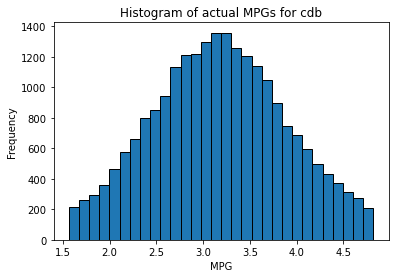

In [163]:
plt.hist(trimmed_validation_cdb['actual_mpg'], bins=30, edgecolor='black') 
plt.xlabel('MPG')
plt.ylabel('Frequency')
plt.title('Histogram of actual MPGs for cdb')
plt.show()

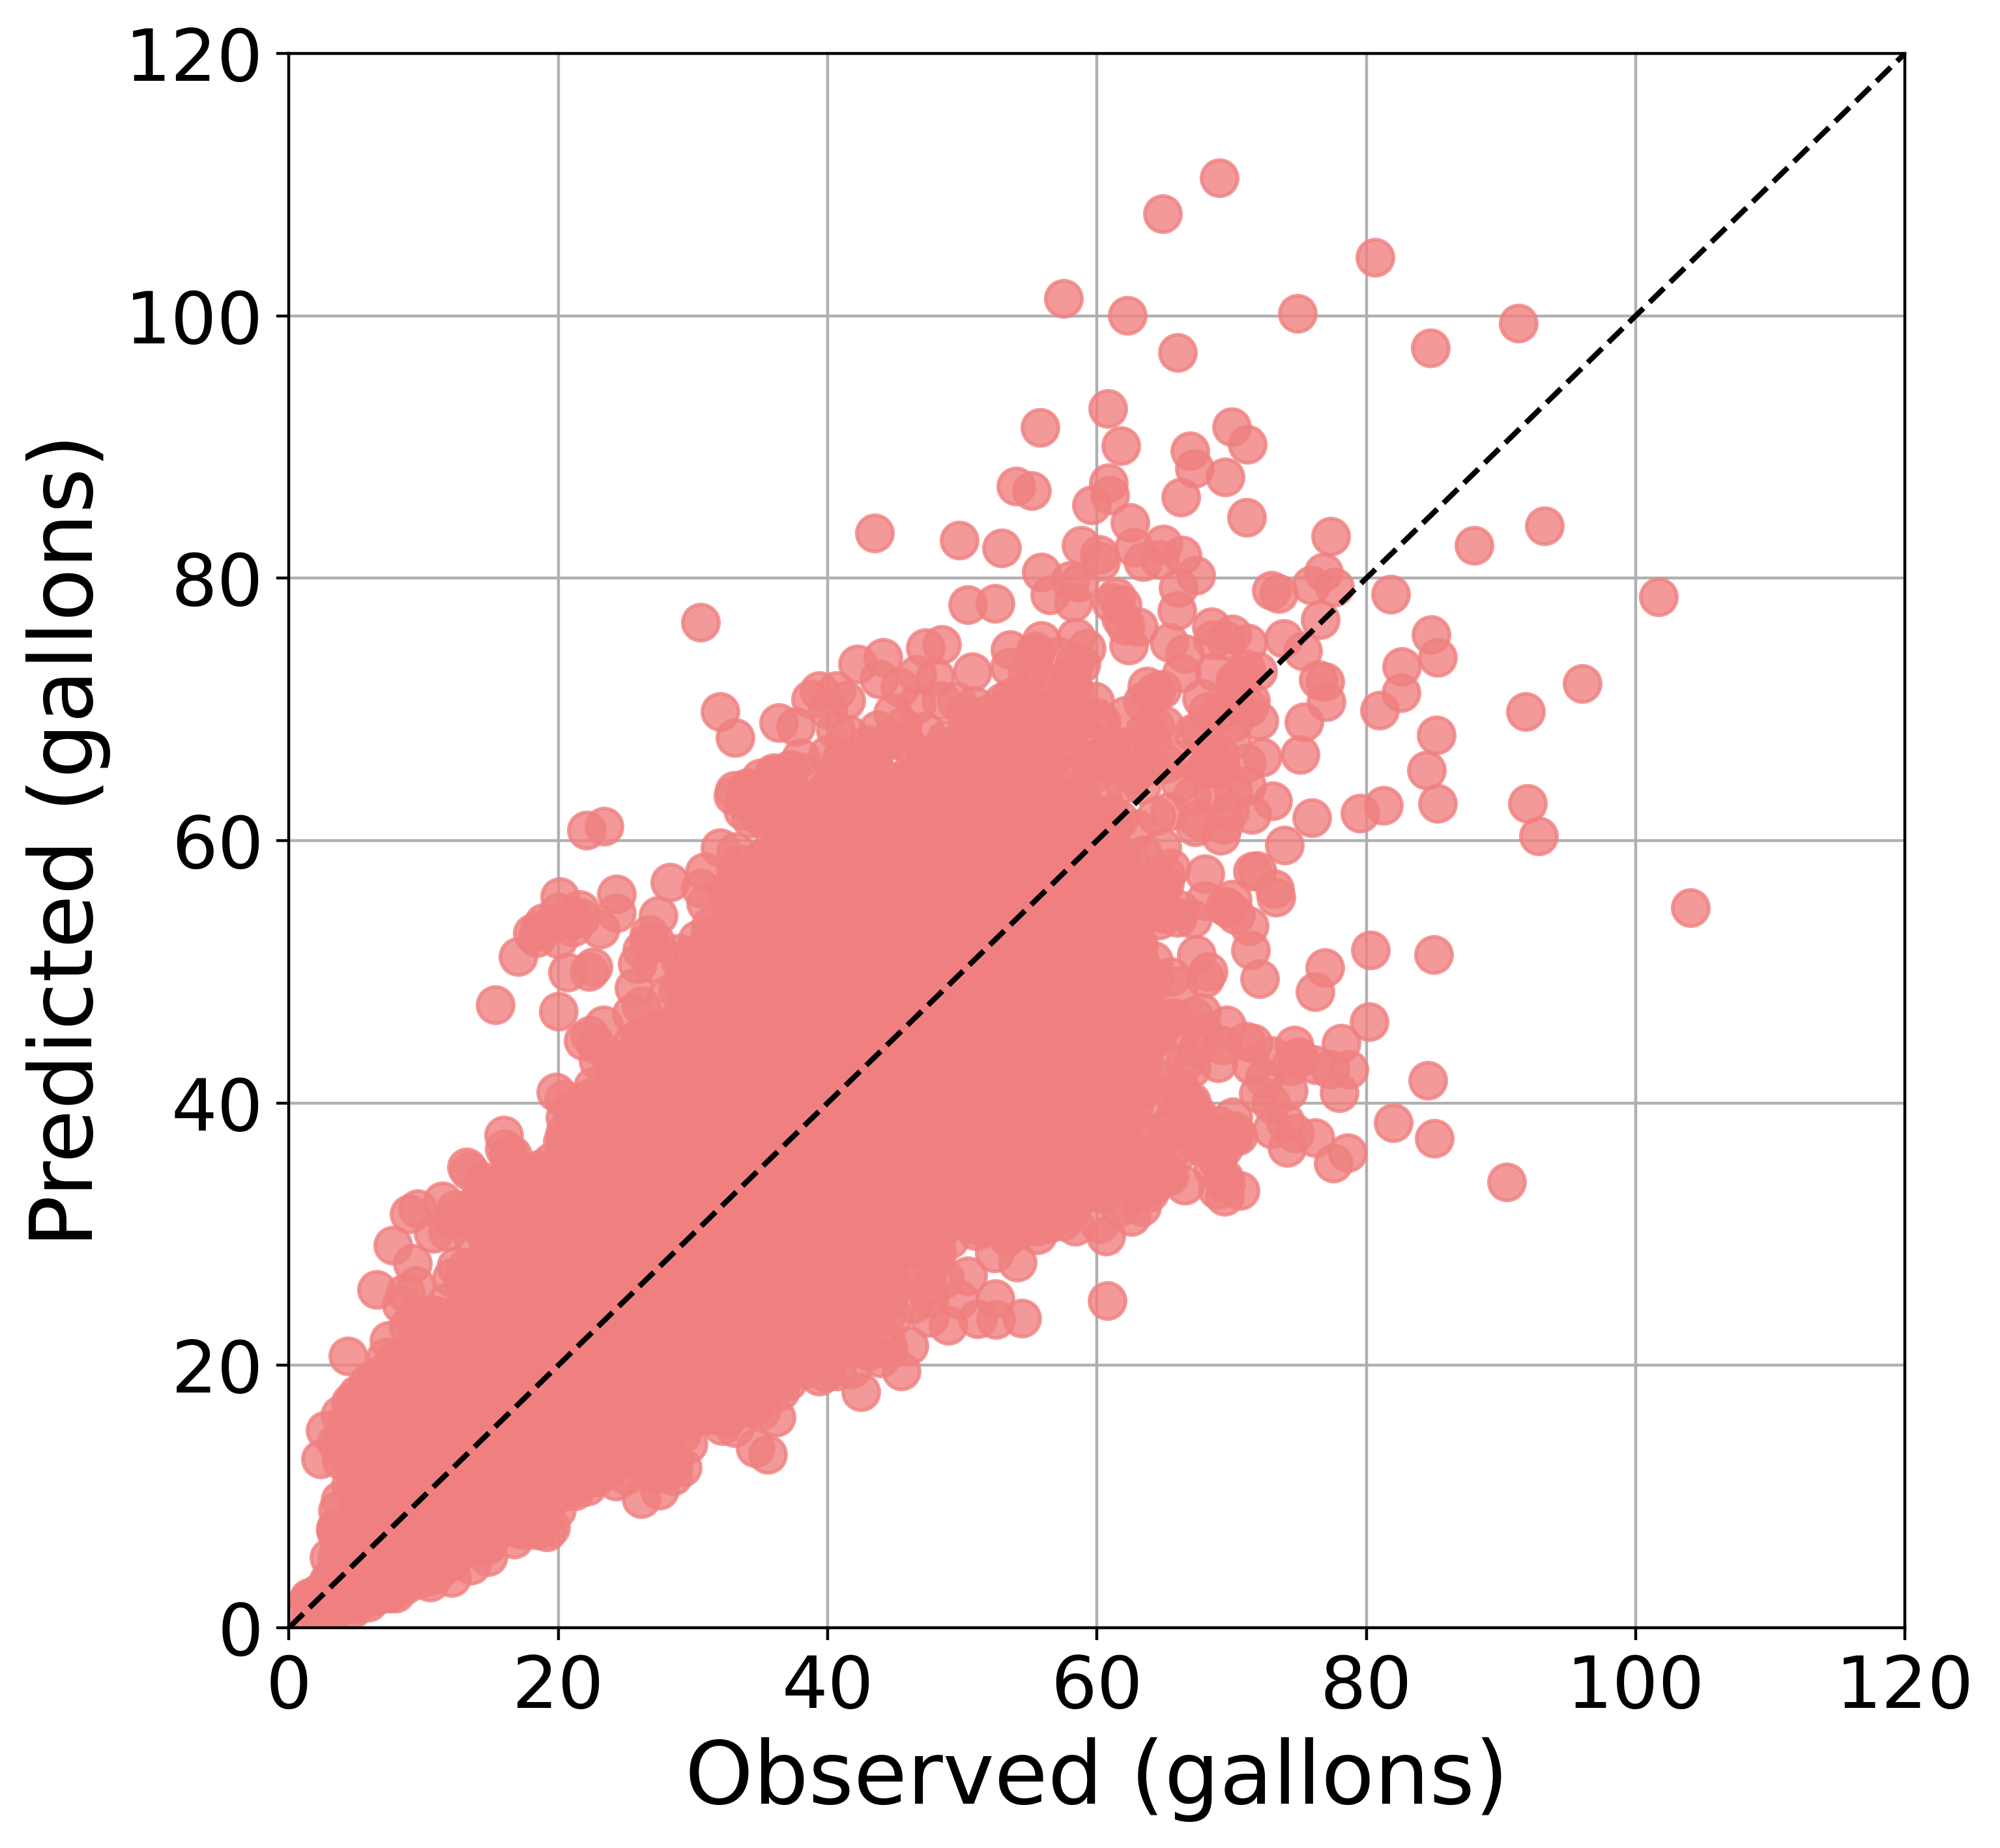

In [204]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(trimmed_validation_cdb['Qty'], trimmed_validation_cdb['Energy'], alpha=0.8, s=100, color='lightcoral', zorder=2)

# Calculate the minimum and maximum limits for x and y axes
xlim = ylim = (0, 120)
xy_min = min(xlim[0], ylim[0])
xy_max = max(xlim[1], ylim[1])

# add a reference line showing perfect agreement between predicted and observed values
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='black', linestyle='dashed', zorder=2)

# set the axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# set the axis labels
plt.ylabel('Predicted (gallons)', fontsize=24)
plt.xlabel('Observed (gallons)', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding gridlines to the plot
plt.grid(True, zorder=1)

# show the plot
plt.show()

In [165]:
trimmed_validation_cdb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_cdb['ServiceDateTime'])
trimmed_validation_cdb = trimmed_validation_cdb.set_index('ServiceDateTime')
weekly_energy_cdb = trimmed_validation_cdb[['Energy','Qty']].resample('W').sum()
weekly_energy_cdb=weekly_energy_cdb.reset_index()

C:\Users\Mahsa\AppData\Local\Temp\ipykernel_19064\2798376440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_validation_cdb['ServiceDateTime'] = pd.to_datetime(trimmed_validation_cdb['ServiceDateTime'])


In [166]:
train_df_cdb_system, test_df_cdb_system = train_test_split(weekly_energy_cdb, test_size=0.2, random_state=42)

In [167]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_df_cdb_system['Qty'], test_df_cdb_system['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_df_cdb_system['Qty'], test_df_cdb_system['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.06
RMSE: 1028.97


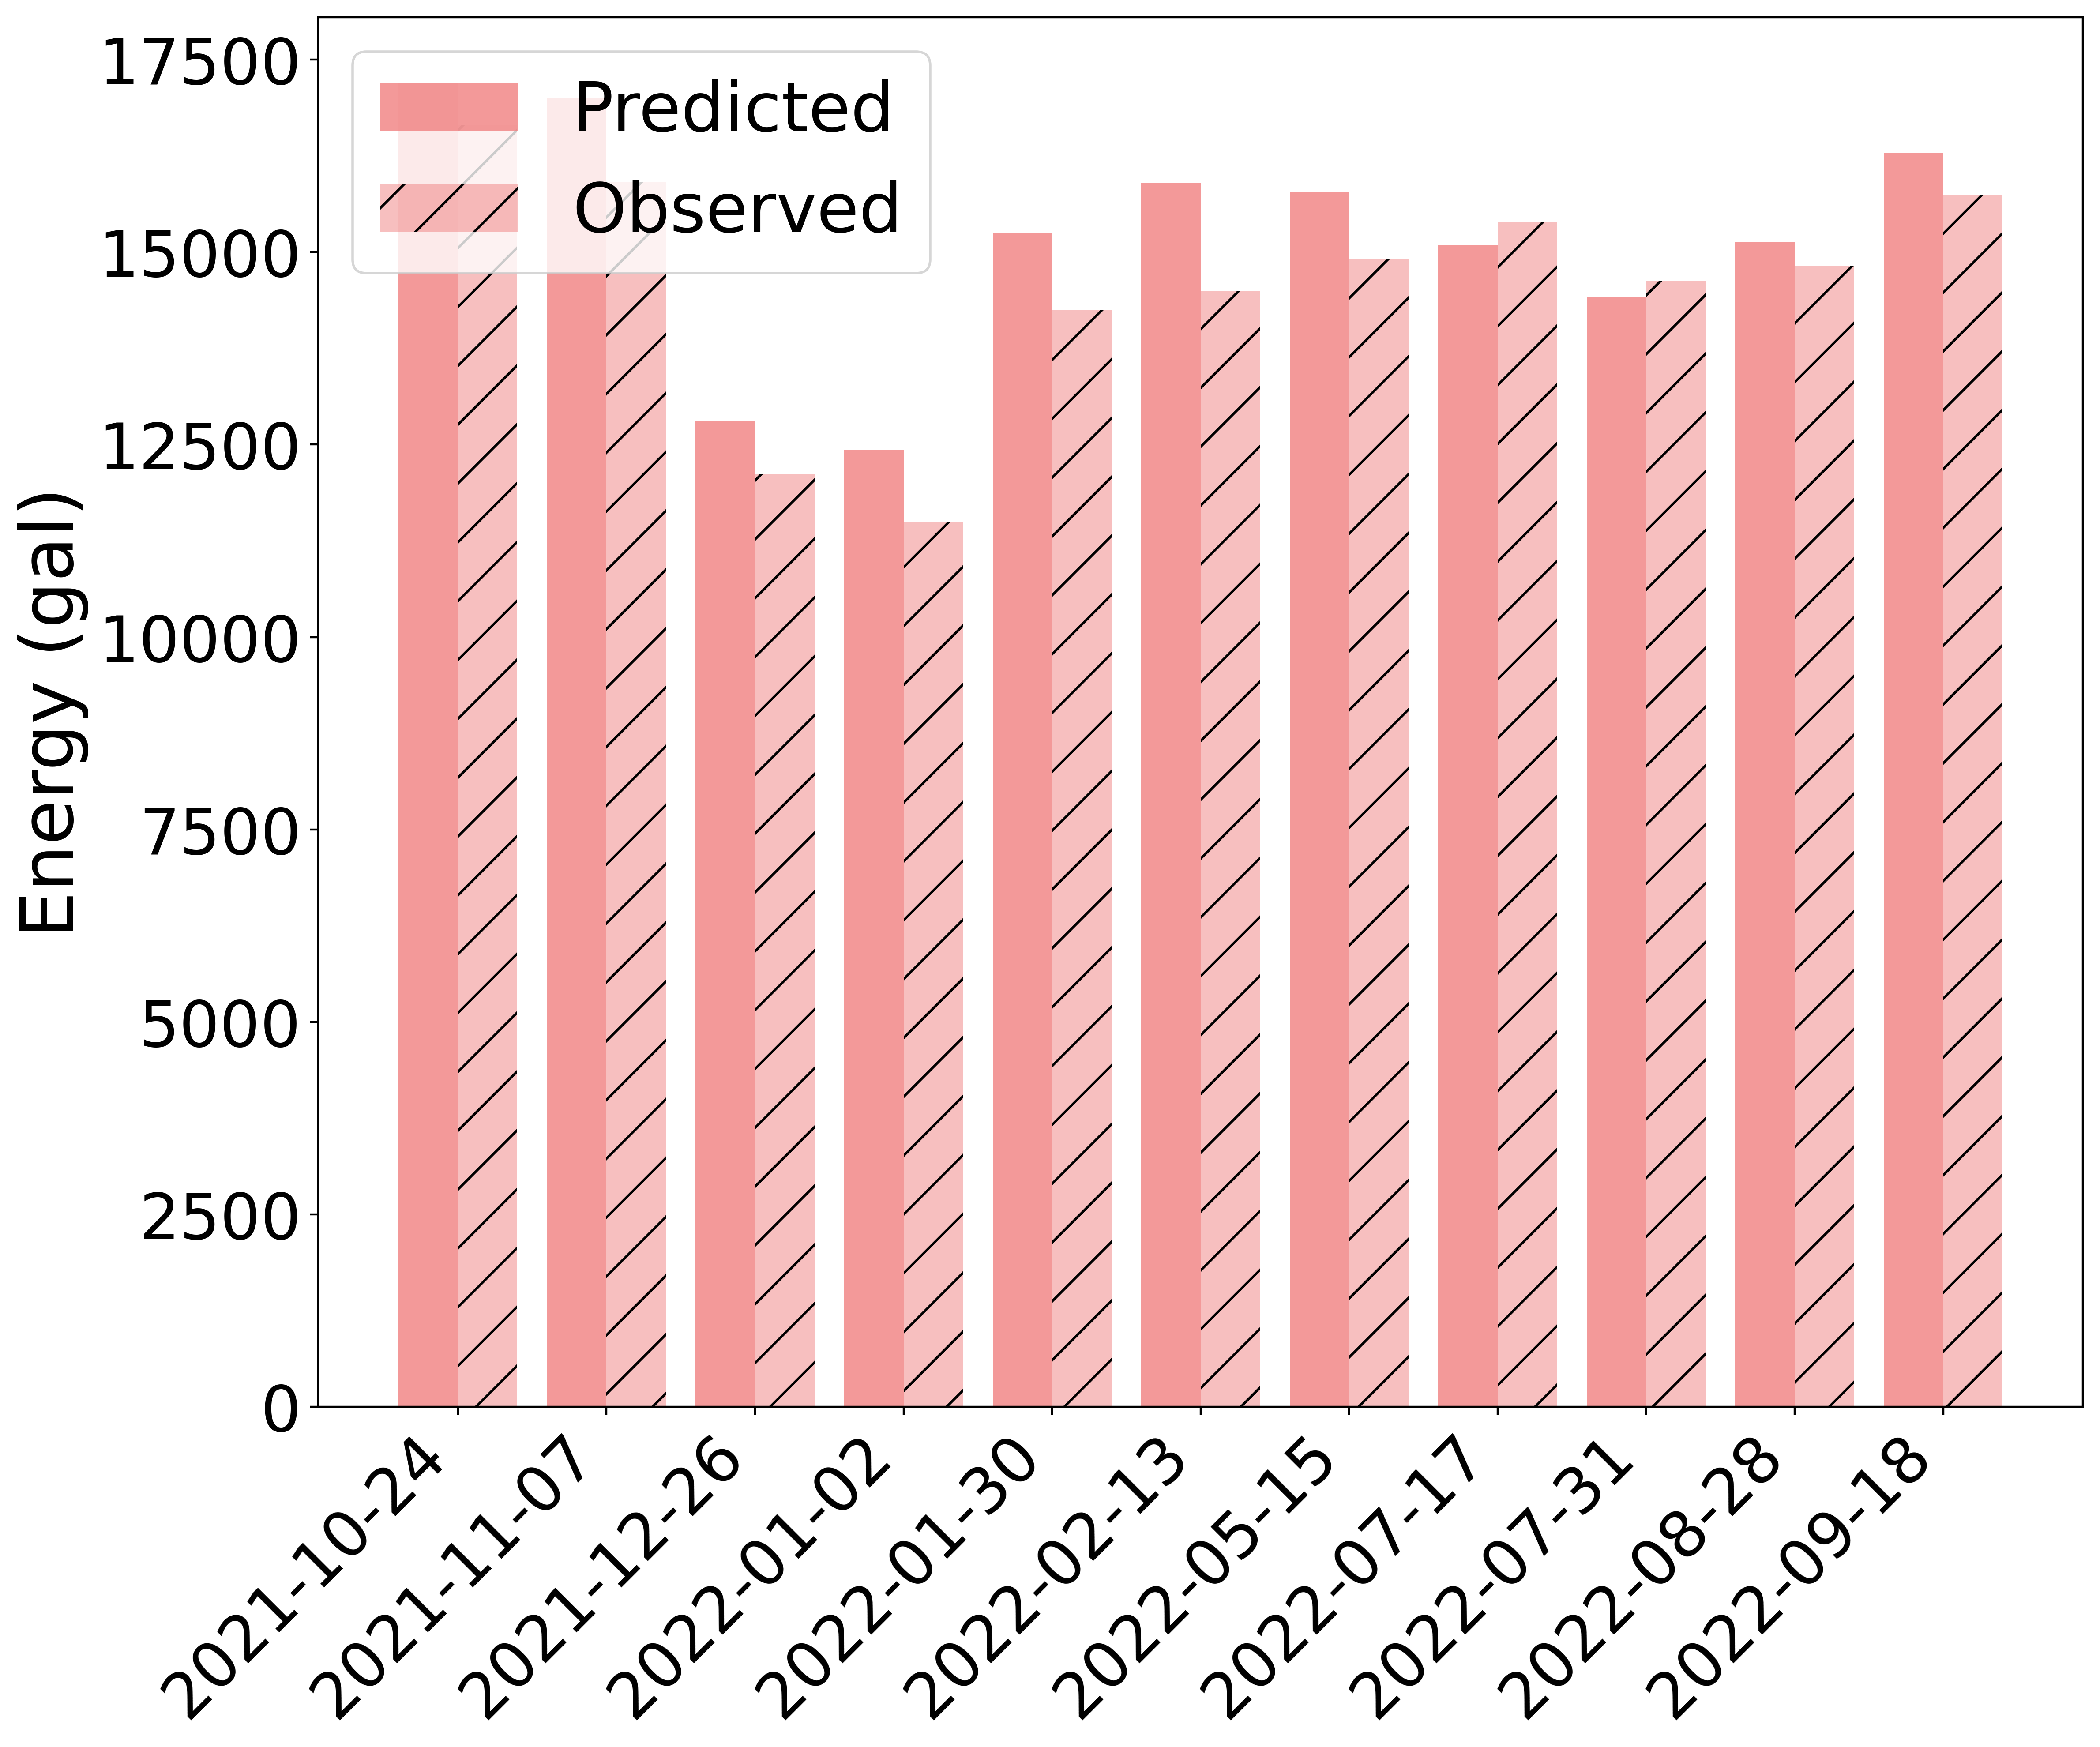

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ServiceDateTime' is a datetime object
test_df_cdb_system['ServiceDateTime'] = pd.to_datetime(test_df_cdb_system['ServiceDateTime'])
test_df_cdb_system = test_df_cdb_system.sort_values('ServiceDateTime')


# Set 'ServiceDateTime' as index for plotting purposes
test_df_cdb_system.set_index('ServiceDateTime', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_df_cdb_system))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_df_cdb_system['Energy'], width=bar_width, color='lightcoral', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_df_cdb_system['Qty'], width=bar_width, color='lightcoral', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_df_cdb_system.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (gal)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout() 

# Save the figure with high resolution
plt.savefig(r'../../figures/validation-CDB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()
